# **SOQ - IR Derivatives Project**
# Buchkov Viacheslav - Modelling TONIA (Tenge OverNight Index Average)
### *This notebook implements fitting and backtesting of 3 groups of models: Vasicek, Hull-White and Neural Networks*.



### Loading data.

In [2]:
!pip install openpyxl
!pip install xlrd
!pip install --upgrade scikit-learn

In [3]:
import datetime as dt

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

PATH = "data/"
RANDOM_SEED = 12

In [4]:
tonia_df = pd.read_excel(f"{PATH}TONIA_240415.xls", skiprows=[0], engine='openpyxl')
tonia_df.head()

Дата  Закрытие  Объем сделок, млрд KZT  Объем сделок, млн USD
0  09.06.14      0.54                   19.46                    NaN
1  10.06.14      1.15                   18.35                    NaN
2  11.06.14      0.54                   16.84                    NaN
3  12.06.14      0.65                   14.27                    NaN
4  13.06.14      0.79                   12.58                    NaN

### Preprocessing.

In [5]:
# As USD volume contains NaNs, will use KZT volume only (if needed in advanced models)
tonia_df.drop(["Объем сделок, млн USD"], axis=1, inplace=True)
tonia_df.rename(columns={"Дата": "date", "Закрытие": "close", "Объем сделок, млрд KZT": "kzt_volume_traded"},
                inplace=True)
tonia_df.head()

date  close  kzt_volume_traded
0  09.06.14   0.54              19.46
1  10.06.14   1.15              18.35
2  11.06.14   0.54              16.84
3  12.06.14   0.65              14.27
4  13.06.14   0.79              12.58

In [6]:
# Set date as index
tonia_df["date"] = pd.to_datetime(tonia_df["date"], format="%d.%m.%y")
tonia_df.set_index("date", inplace=True)
# Close to decimal value
tonia_df["close"] = tonia_df["close"] / 100
tonia_df.head()

close  kzt_volume_traded
date                                 
2014-06-09  0.0054              19.46
2014-06-10  0.0115              18.35
2014-06-11  0.0054              16.84
2014-06-12  0.0065              14.27
2014-06-13  0.0079              12.58

In [7]:
def plot_rates(data: pd.Series, simulated: [pd.DataFrame, None] = None, opacity: float = .03) -> None:
    plt.figure(figsize=(14, 7))

    plt.plot(data, label="close")

    if simulated is not None:
        colors = plt.colormaps["BuPu"](np.linspace(0.0, 1.0, simulated.shape[1]))
        for i in range(simulated.shape[1]):
            plt.plot(simulated.iloc[:, i], color=colors[i], alpha=opacity)

        plt.axvline(x=simulated.index[0], color="m", linestyle="--")

    plt.legend(["TONIA"])
    plt.title("TONIA Rate Time Series")

    plt.xlabel("Date")
    plt.ylabel("TONIA")

    # TODO: Highlight quantiles 0.25, 0.5, 0.75

    plt.show()

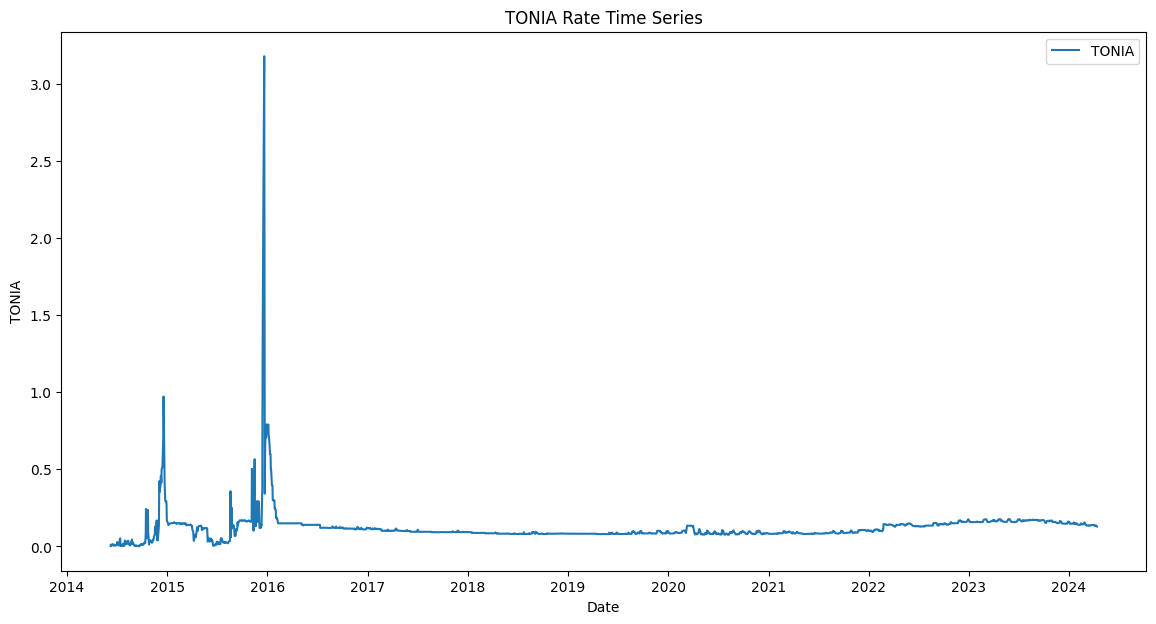

In [8]:
plot_rates(tonia_df["close"])

Overall index demonstrates several sharp spikes in early years due to less developed methodology (until 2020 it was calculated as weighted average of REPO without dropping the 5% quantiles of outliers: https://kase.kz/ru/money_market/repo-indicators/tonia/) and overall less advanced market participants.

In [9]:
tonia_df.describe()

close  kzt_volume_traded
count  2421.000000        2421.000000
mean      0.117749         345.226898
std       0.110004         262.679119
min       0.001400           2.290000
25%       0.083200         182.970000
50%       0.097100         277.300000
75%       0.142500         447.830000
max       3.179500        1485.870000

## Vasicek Model.

Let's create an abstract class first, which will define the behaviour, required for further backtesting.

In [10]:
from abc import abstractmethod


class InterestRateModel:
    CALENDAR_DAYS = 365
    DEFAULT_TEST_LENGTH = .25

    def __init__(self, target_column: str = "close", n_paths: int = 100, random_seed: [int, None] = None) -> None:
        self.target_column = target_column
        self.n_paths = n_paths
        self.random_seed = random_seed

        self.model = None
        self._sigma = None

    @abstractmethod
    def fit_regression(self, data: pd.DataFrame) -> None:
        pass

    @abstractmethod
    def get_simulation_drift(self, r0: float, terms: list[float]) -> np.array:
        pass

    @abstractmethod
    def fit(self, *args, **kwargs) -> None:
        pass

    @property
    def sigma(self) -> float:
        if self._sigma is None:
            raise ValueError("Model error is not calculated yet!")
        return self._sigma

    @sigma.setter
    def sigma(self, sigma: float) -> None:
        self._sigma = sigma

    def simulate(self, r0: float, terms: list[float]) -> np.array:
        if self.random_seed is not None:
            np.random.seed(self.random_seed)
            torch.manual_seed(self.random_seed)

        paths = []
        for _ in range(self.n_paths):
            path = [r0]
            for _ in terms:
                path.append((self.get_simulation_drift(path[-1], terms=tuple([1] * 2)) + np.random.normal(scale=self.sigma)).tolist()[0])
            paths.append(path[1:])
        return np.array(paths)

    def run_simulation(self, *args, **kwargs) -> None:
        if "data" in kwargs.keys():
            data = kwargs.get("data")
        elif len(args) > 0:
            data = args[0]
        else:
            raise ValueError("No arguments provided.")

        if "test_length" in kwargs.keys():
            test_length = kwargs.get("test_length")
        elif len(args) > 1:
            test_length = args[1]
        else:
            test_length = self.DEFAULT_TEST_LENGTH

        self.fit(*args, **kwargs)

        start_date = data.index[-1]
        dates = pd.date_range(start=start_date, periods=int(test_length * data.shape[0]), freq="1D")

        if self.random_seed is not None:
            np.random.seed(self.random_seed)
            torch.manual_seed(self.random_seed)

        simulated = self.simulate(r0=data[self.target_column].iloc[-1], terms=tuple((
                (dates.shift(1) - dates).days / self.CALENDAR_DAYS).to_series().cumsum().to_list()))
        simulated = pd.DataFrame(simulated.T, columns=[self.target_column] * simulated.shape[0])

        simulated["index"] = dates
        simulated.set_index("index", inplace=True)

        plot_rates(data[self.target_column], simulated)

Now let's create the Vasicek Model, using sklearn for linear regression fitting.

In [11]:
from sklearn.linear_model import LinearRegression


class VasicekModel(InterestRateModel):
    def __init__(self, target_column: str = "close", n_paths: int = 100, random_seed: [int, None] = None) -> None:
        super().__init__(target_column)

        self.target_column = target_column

        self.n_paths = n_paths
        self.random_seed = random_seed

        self.dt = None
        self._r2_fitted = None

    def _create_lags(self, data: pd.DataFrame, n_lags: int) -> tuple[pd.DataFrame, list[str]]:
        # lag_columns = []
        # for lag in range(1, n_lags + 1):
        #     column_name = f"{self.target_column}_t-{lag}"
        #     data[column_name] = tonia_df[self.target_column].shift(lag)
        #     lag_columns.append(column_name)
        # return data.iloc[n_lags:, :], lag_columns
        data["close_t-1"] = data[self.target_column].shift(1)
        return data.iloc[1:], ["close_t-1"]

    @property
    def r2_score(self) -> float:
        if self._r2_fitted is None:
            raise ValueError("Regression is not fitted yet!")
        return self._r2_fitted

    @staticmethod
    def _resample_to_daily(data: pd.DataFrame) -> pd.DataFrame:
        return data.resample("1D").ffill()

    def lambda_(self, *args, **kwargs) -> float:
        if self.model is None:
            raise ValueError("Regression is not fitted yet!")
        return (1 - self.model.coef_[0]) / self.dt

    def mu_(self, *args, **kwargs) -> float:
        if self.model is None:
            raise ValueError("Regression is not fitted yet!")
        return self.model.intercept_ / (1 - self.model.coef_[0])

    def fit_regression(self, data: pd.DataFrame, n_lags: int = 1) -> None:
        assert n_lags == 1, "Only one lag can be fitted right now."

        data = self._resample_to_daily(data)
        data, lag_columns = self._create_lags(data, n_lags=n_lags)

        X = data[lag_columns].to_numpy()
        y = data[self.target_column].to_numpy()

        if n_lags == 1:
            X = X.reshape(-1, 1)

        # Linreg by analytical solution => no need to fix random seed
        self.model = LinearRegression()
        self.model.fit(X, y)

        self.dt = (data.index.to_series() - data.index.to_series().shift(1)).dt.days.min() / self.CALENDAR_DAYS
        self.sigma = np.std(y) * np.sqrt(self.dt)
        self._r2_fitted = self.model.score(X, y)

    def get_simulation_drift(self, r0: float, terms: list[float]) -> np.array:
        if self.model is None:
            raise ValueError("Regression is not fitted yet!")
        rates = [r0]
        t_old = terms[0]
        for t in terms[1:]:
            dr = self.lambda_(t) * (self.mu_(t) - rates[-1]) * (t - t_old)
            rates.append(rates[-1] + dr)
            t_old = t
        return np.array(rates[1:])

    def fit(self, *args, **kwargs) -> None:
        if "data" in kwargs.keys():
            self.fit_regression(kwargs.get("data"))
        elif len(args) > 0:
            self.fit_regression(args[0])
        else:
            raise ValueError("No arguments provided.")

In [12]:
vs = VasicekModel(random_seed=RANDOM_SEED)
vs.fit_regression(tonia_df)
vs.simulate(tonia_df.close.iloc[-1], terms=[1 / 365] * 100)

array([[ 0.13209923,  0.12792234,  0.1294084 , ...,  0.04282011,
         0.03953168,  0.04074486],
       [ 0.12082913,  0.11350763,  0.11360531, ...,  0.01230766,
         0.00642927, -0.0033493 ],
       [ 0.13231093,  0.12852054,  0.13336781, ...,  0.05670074,
         0.06489906,  0.0489314 ],
       ...,
       [ 0.1186895 ,  0.12408816,  0.12971857, ...,  0.11161876,
         0.10961948,  0.10452251],
       [ 0.13512932,  0.13862804,  0.13257176, ...,  0.0220455 ,
         0.01867307,  0.00922012],
       [ 0.11509929,  0.11930352,  0.10963953, ...,  0.02624825,
         0.02571894,  0.02614006]])

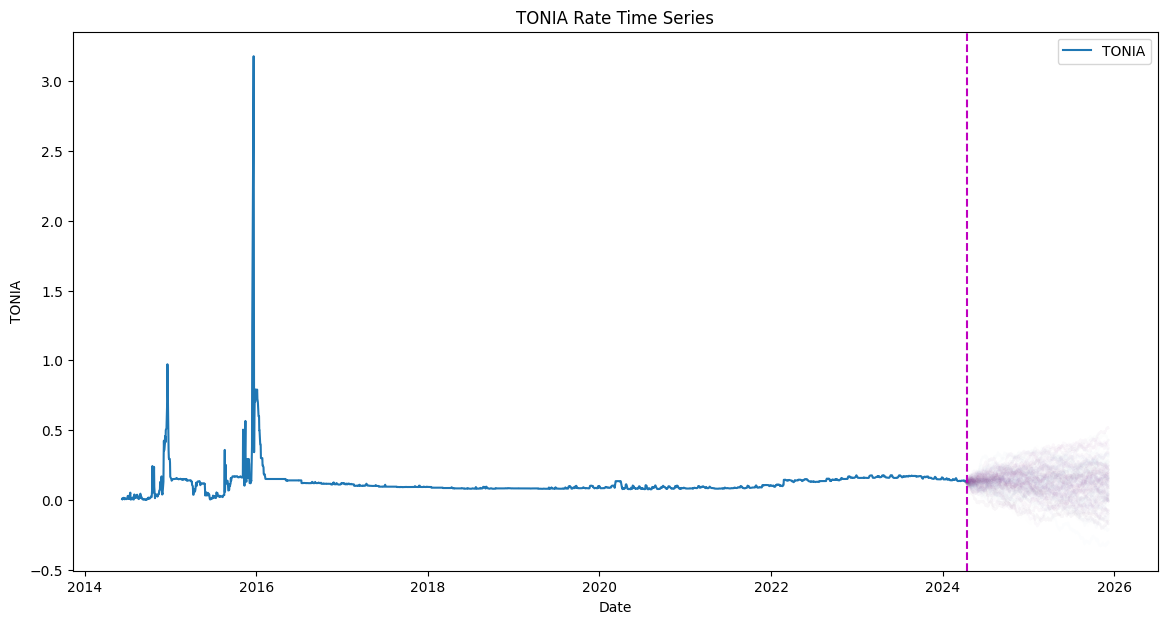

In [13]:
vs.run_simulation(tonia_df)

Checking the $R^2$ score for the fitted regression.

In [14]:
vs.r2_score

0.8424333861836162

Looking at the simulation result and $R^2$ it looks like our model overfits to outliers in early days of index - as the KASE index authorities decided to drop outliers, let's do the same and create the new dataset.

First of all, let's drop extreme outliers only - ones with Z-score of 3 and larger.

In [15]:
from scipy import stats

tonia_df_no_outliers = tonia_df[(np.abs(stats.zscore(tonia_df["close"])) < 3)]

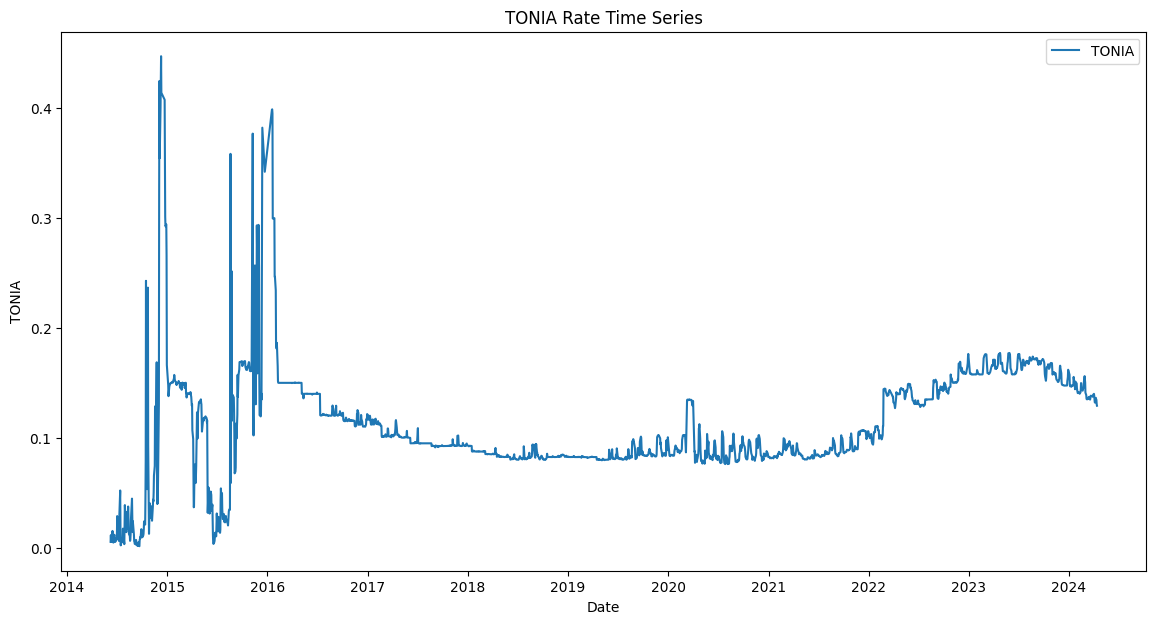

In [16]:
plot_rates(tonia_df_no_outliers["close"])

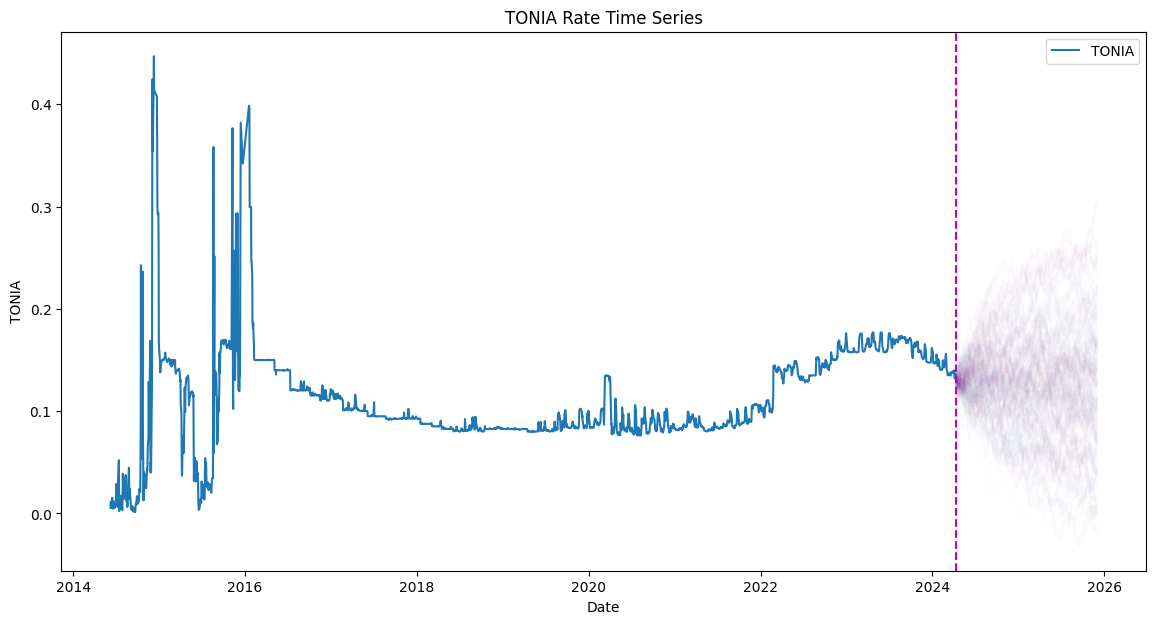

In [17]:
vs_new = VasicekModel(random_seed=RANDOM_SEED)
vs_new.run_simulation(tonia_df_no_outliers)

In [18]:
vs_new.r2_score, vs_new.sigma

(0.9335064108391858, 0.0027948104577242604)

Secondly, we can check, whether simulation is different for stricter outlier dropping - limiting Z-score by 1.96.

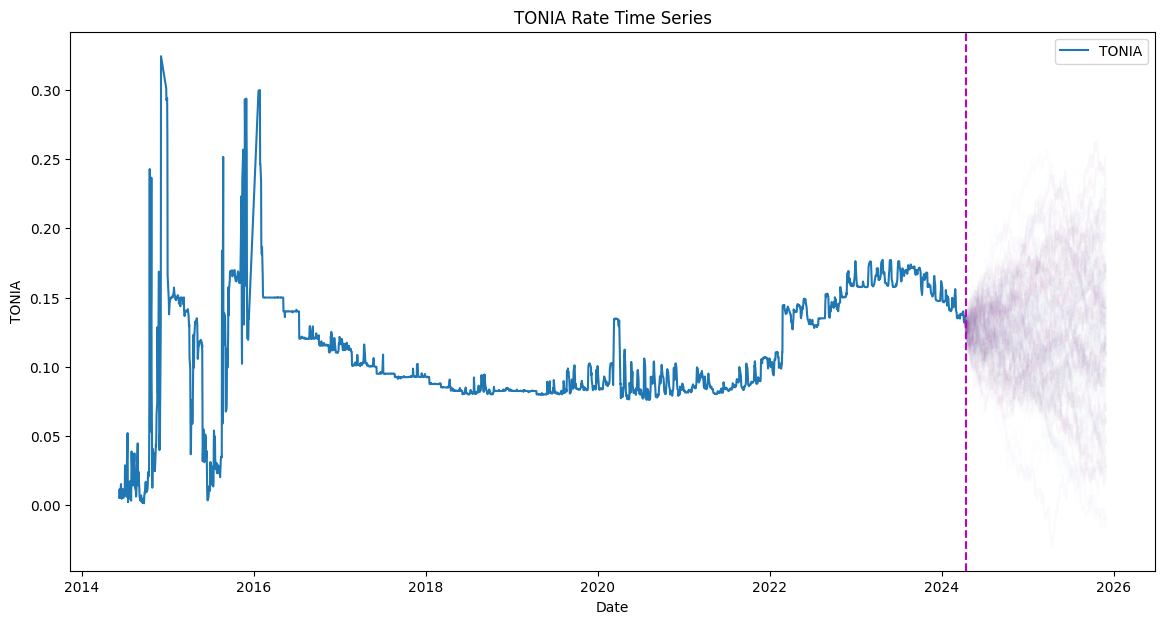

In [19]:
VasicekModel(random_seed=RANDOM_SEED).run_simulation(tonia_df[(np.abs(stats.zscore(tonia_df["close"])) < 1.96)])

New $R^2$ is way higher and the overall simulation looks as being way more logical. However, we can try another idea - let's just drop inconsistent part of dataset and use only financially logical datapoints.

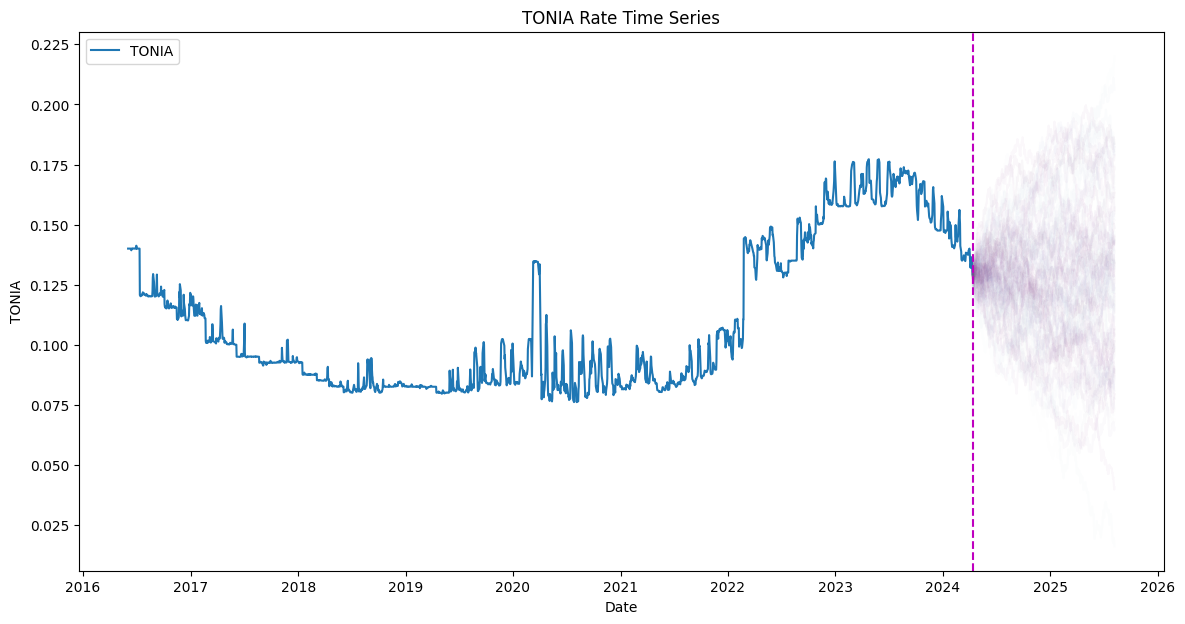

In [20]:
VasicekModel(random_seed=RANDOM_SEED).run_simulation(tonia_df[tonia_df.index > dt.datetime(year=2016, month=6, day=1)])

Such dataset looks way better for our task, and the overall model quality is way higher. Thus, let's stick with this new dataset - $tonia\_recent$.

In [21]:
tonia_recent = tonia_df[tonia_df.index > dt.datetime(year=2016, month=6, day=1)]
vs_final = VasicekModel(random_seed=RANDOM_SEED)
vs_final.fit(tonia_recent)
vs_final.r2_score

0.9927956546003394

## Hull-White.

For the Hull-White model we need the yield curve of risk-free rates for our overnight interest rate modelling. The first basic idea is to use the yields of the government securities, i.e. G-curve.

Even though, while the model here seems to concern the REPO rates (with government securities as the collateral, i.e., colleteralized deals with the Central Counterparty), G-curve might bear slightly larger risk due to being uncolleteralized deals, however, let's disregard such a discrepancy for simplicity.

### Loading curve data.

Let's check KASE website for the G-curve - https://kase.kz/en/gsecs/.

In [22]:
curve_data = pd.read_csv(f"{PATH}curve_data.csv", sep="\t", skiprows=1, header=None).dropna(axis=0, how="any").iloc[:,
             [-1, -2]]
curve_data.columns = ["maturity", "ytm"]
curve_data

maturity   ytm
0        5 (0)   0,3
2       14 (0)   0,0
4       17 (0)  11,8
6       20 (0)   0,3
8       20 (0)   0,3
..         ...   ...
490  4616 (13)  10,5
492  5285 (15)  11,5
494  5500 (15)  12,2
496  5711 (16)  10,5
498  7361 (20)  11,0

[250 rows x 2 columns]

### Preprocessing.

In [22]:
curve_data["maturity"] = curve_data["maturity"].apply(lambda x: int(x.split(" ")[0]) / InterestRateModel.CALENDAR_DAYS)
curve_data

maturity   ytm
0     0.013699   0,3
2     0.038356   0,0
4     0.046575  11,8
6     0.054795   0,3
8     0.054795   0,3
..         ...   ...
490  12.646575  10,5
492  14.479452  11,5
494  15.068493  12,2
496  15.646575  10,5
498  20.167123  11,0

[250 rows x 2 columns]

In [24]:
curve_data["ytm"] = curve_data["ytm"].apply(
    lambda x: float(x.replace(",", ".").replace("-", "")) / 100 if x != "–" else np.nan)
curve_data.dropna(subset=["ytm"], inplace=True)
# Website does not provide the data for the fixed coupon vs floater classification
# Therefore, let's drop bonds with YTM below 1% (hoping that those are the floaters)
curve_data = curve_data[curve_data["ytm"] > 0.01]
curve_data.set_index("maturity", inplace=True)
curve_data

ytm
maturity        
17 (0)     0.118
35 (0)     0.133
69 (0)     0.126
111 (0)    0.121
156 (0)    0.142
...          ...
4616 (13)  0.105
5285 (15)  0.115
5500 (15)  0.122
5711 (16)  0.105
7361 (20)  0.110

[164 rows x 1 columns]

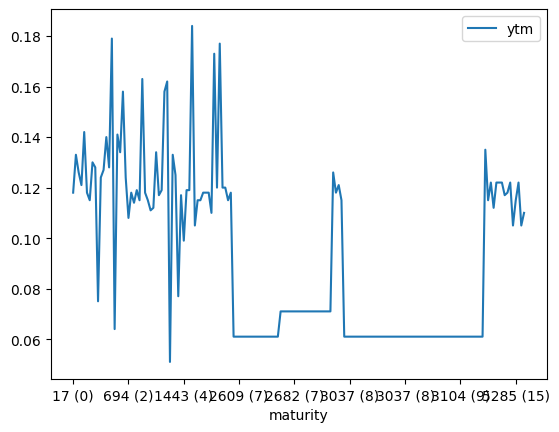

In [27]:
curve_data.plot();

Here we can see that the curve contains some outliers - some of the bonds (randomly chosen for check, but no details on the website directly) are the municipal bonds (according to the website - i.e., not risk-free bonds). Moreover, some bonds are floaters, thus, we cannot infer spot curve from those directly, without calculating additional data.

Therefore, it seems that we have to look for another spot curve on the website.

### Nelson-Siegel Interpolation.

Even though the website does not contain the risk-free spot curve or comprehensive list of government fixed coupon bonds, there is a curve that suits perfectly for our task - NSS-interpolated curve: https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://kase.kz/ru/documents/curve/&ved=2ahUKEwj7rff0jNSFAxUjEBAIHdysB7MQFnoECA8QAQ&usg=AOvVaw3W1S3CVf2k9AytgMDOUTyP.

Therefore, let's just download current and historical NSS parameters and infer the curve from those.

In [34]:
ns_curve_params = pd.read_excel(f"{PATH}en_curve150424.xls").iloc[3:, :]
ns_curve_params.columns = ["date", "b0", "b1", "b2", "tau"]
ns_curve_params["date"] = pd.to_datetime(ns_curve_params["date"])
ns_curve_params.set_index("date", inplace=True)
ns_curve_params

b0        b1        b2    tau
date                                           
2024-04-15  0.114791  0.006718 -0.018493      1
2024-04-12  0.116919   0.00583 -0.030904      1
2024-04-11  0.120152  0.006128 -0.050638      1
2024-04-10  0.117953   0.00868 -0.043068   0.91
2024-04-09  0.115784  0.012081 -0.034621      1
...              ...       ...       ...    ...
2019-11-08  0.087513 -0.005761  0.053633  0.156
2019-11-07  0.086921 -0.005163   0.05404  0.176
2019-11-06  0.087335 -0.006525  0.055357  0.156
2019-11-05  0.087261 -0.007388    0.0574  0.156
2019-11-04  0.087124  -0.00709  0.058693  0.156

[1090 rows x 4 columns]

Let's create the abstract class for holding and calculating the yield curve data from some pattern.

In [35]:
class YieldCurve:
    TARGET_COLUMN = "ytm"
    DISCOUNT_FACTOR_COLUMN = "discount_factor"
    FWD_RATE_COLUMN = "fwd_rate"

    def __init__(self, *args, **kwargs) -> None:
        self._rates_df = None
        self._discount_factors = None
        self._instant_fwd_rate = None

    @abstractmethod
    def get_rates(self, terms: list[float]) -> np.array:
        pass

    def create_curve(self, terms: list[float]) -> None:
        self._rates_df = pd.DataFrame(self.get_rates(terms), index=terms, columns=[self.TARGET_COLUMN])
        self._create_discount_factors()
        self._create_instant_fwd_rates()

    def _create_discount_factors(self) -> pd.DataFrame:
        if self._rates_df is None:
            raise ValueError("Rate data is not fitted yet!")
        discount_factors = np.exp(-self._rates_df[self.TARGET_COLUMN] * self._rates_df.index)
        self._discount_factors = pd.DataFrame(discount_factors, index=self._rates_df.index,
                                              columns=[self.DISCOUNT_FACTOR_COLUMN])
        return self._discount_factors

    def _create_instant_fwd_rates(self) -> pd.DataFrame:
        if self._discount_factors is None:
            raise ValueError("Discount factor data is not fitted yet!")

        t_old = self._rates_df.index[0]
        instant_fwd_rates = []
        for t in self._rates_df.index[1:]:
            dt = t - t_old
            instant_fwd_rates.append(-1 / dt * (np.log(
                self._discount_factors.loc[t, self.DISCOUNT_FACTOR_COLUMN] / self._discount_factors.loc[
                    t_old, self.DISCOUNT_FACTOR_COLUMN])))
            t_old = t
        self._instant_fwd_rate = pd.DataFrame(instant_fwd_rates, index=self._rates_df.index[1:],
                                              columns=[self.FWD_RATE_COLUMN])
        return self._instant_fwd_rate

    @property
    def curve(self) -> pd.DataFrame:
        if self._rates_df is None:
            raise ValueError("Rate data is not fitted yet! Call .create_curve() first.")
        return self._rates_df

    @property
    def discount_factors(self) -> pd.DataFrame:
        return self._discount_factors

    @property
    def instant_fwd_rate(self) -> pd.DataFrame:
        return self._instant_fwd_rate

Here let's use the abstract class to create the NSS curve.

In [36]:
class NelsonSiegelCurve(YieldCurve):
    def __init__(self, b0: float, b1: float, b2: float, tau: float) -> None:
        super().__init__()

        self.b0 = b0
        self.b1 = b1
        self.b2 = b2
        self.tau = tau

    def get_rates(self, terms: list[float]) -> np.array:
        terms = np.array(terms)
        return self.b0 + (self.b1 + self.b2) * self.tau / terms * (1 - np.exp(-terms / self.tau)) - self.b2 * np.exp(
            -terms / self.tau)

In [37]:
curve_data.index.max()

'938 (3)'

Maximum date for the created curve data term is silghtly above 20 years => let's restrict our curve to 25 years of maturity.

In [38]:
ns_curve = NelsonSiegelCurve(
    b0=ns_curve_params["b0"].iloc[0],
    b1=ns_curve_params["b1"].iloc[0],
    b2=ns_curve_params["b2"].iloc[0],
    tau=ns_curve_params["tau"].iloc[0],
)
ns_curve.create_curve(terms=np.linspace(1 / InterestRateModel.CALENDAR_DAYS, 25., 100))

In [39]:
ns_curve.instant_fwd_rate.shape

(99, 1)

In [40]:
ns_curve = NelsonSiegelCurve(
    b0=ns_curve_params["b0"].iloc[0],
    b1=ns_curve_params["b1"].iloc[0],
    b2=ns_curve_params["b2"].iloc[0],
    tau=ns_curve_params["tau"].iloc[0],
)
ns_curve.create_curve(terms=np.linspace(1 / InterestRateModel.CALENDAR_DAYS, 25., 10_000))

In [41]:
ns_rates = ns_curve.curve
ns_rates

ytm
0.00274   0.121475
0.00524   0.121444
0.00774   0.121412
0.01024   0.121381
0.01274   0.121350
...            ...
24.99000  0.114320
24.99250  0.114320
24.99500  0.114320
24.99750  0.114320
25.00000  0.114320

[10000 rows x 1 columns]

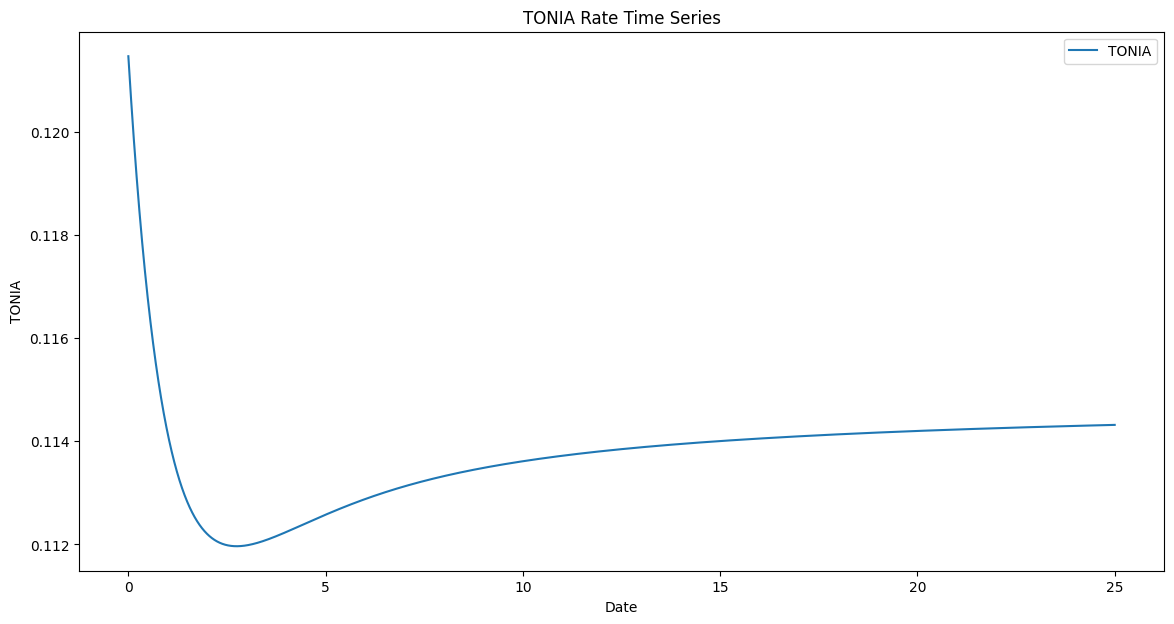

In [42]:
plot_rates(ns_rates)

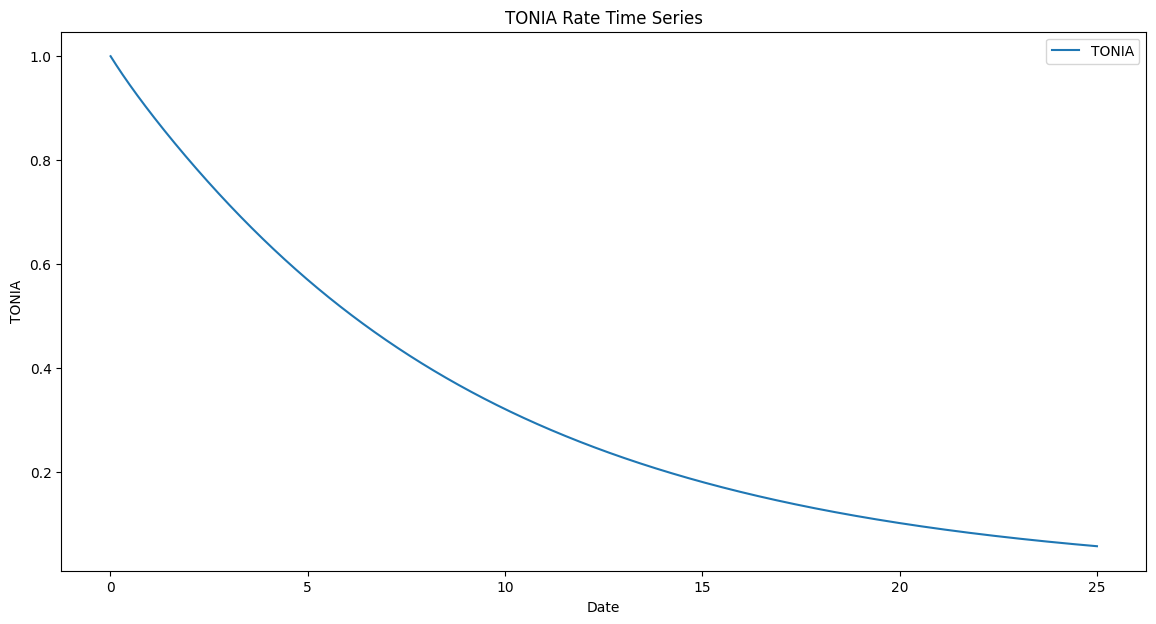

In [43]:
plot_rates(ns_curve.discount_factors)

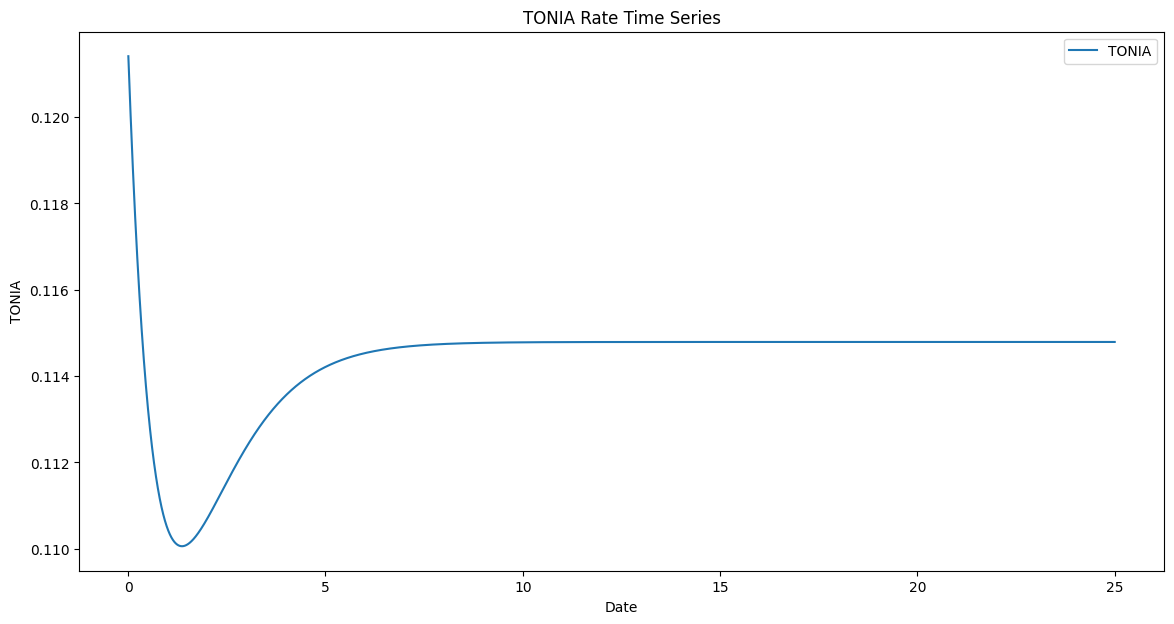

In [44]:
plot_rates(ns_curve.instant_fwd_rate)

## Fitting Hull-White theta.

Let's create the Hull-White model. Hull-White is simply the Vasicek with theta (mu) fitted into the market - setting theta such that model's theoretical bond prices are equal to the observed market bond prices (=discount factors).

Therefore, we can inherit our model from Vasicek realization and just substitute $mu\_(\cdot)$ function with the fitted into the market.

In [45]:
class HullWhiteModel(VasicekModel):
    MU_COLUMN = "mu"

    def __init__(self, target_column: str = "close", n_paths: int = 100, random_seed: [int, None] = None) -> None:
        super().__init__(target_column, n_paths, random_seed)

        self._mu_curve = None

    def mu_(self, t: float) -> float:
        if self._mu_curve is None:
            raise ValueError("Model is not calibrated to the market yet! Call .calibrate_mu(yield_curve) first.")
        index = np.absolute(self._mu_curve[:, 0] - t).argmin()
        return self._mu_curve[index, 1]

    def calibrate_mu(self, yield_curve: YieldCurve) -> None:
        t_old = yield_curve.instant_fwd_rate.index[0]
        fwd_rate_old = yield_curve.instant_fwd_rate.iloc[0, 0]
        mu = []
        for t, fwd_rate in yield_curve.instant_fwd_rate.iloc[1:, :].itertuples():
            dfwd_rate = (fwd_rate - fwd_rate_old) / (t - t_old)

            # TODO: check that not constant
            mu_bootstrapped = (dfwd_rate + self.lambda_(t) * fwd_rate + self.sigma ** 2 / (2 * self.lambda_(t)) * (
                    1 - np.exp(-2 * self.lambda_(t) * t)))
            # According to https://quant.stackexchange.com/questions/38739/how-to-get-set-the-theta-function-in-the-hull-white-model-to-replicate-the-curre
            # , we estimate theta(t) * kappa (under "Slightly rewriting your SDE") => need to divide by kappa <=> divide by lambda in this notation
            mu_bootstrapped /= self.lambda_(t)
            mu.append(mu_bootstrapped)

            fwd_rate_old = fwd_rate
            t_old = t

        self._mu_curve = pd.DataFrame(mu, index=yield_curve.instant_fwd_rate.index[1:],
                                      columns=[self.MU_COLUMN]).reset_index().to_numpy()

    def fit(self, **kwargs) -> None:
        self.fit_regression(kwargs.get("data"))
        self.calibrate_mu(kwargs.get("yield_curve"))

In [36]:
hwm = HullWhiteModel(random_seed=RANDOM_SEED)
hwm.fit_regression(tonia_recent)
hwm.calibrate_mu(ns_curve)
hwm.simulate(tonia_df.close.iloc[-1], terms=[1 / 365] * 100)

array([[0.12994025, 0.12887378, 0.12925321, ..., 0.10714482, 0.1063052 ,
        0.10661495],
       [0.12706269, 0.1251933 , 0.12521824, ..., 0.09935415, 0.09785324,
        0.09535649],
       [0.12999431, 0.12902652, 0.13026416, ..., 0.11068893, 0.11278219,
        0.10870521],
       ...,
       [0.12651638, 0.12789481, 0.1293324 , ..., 0.12471102, 0.12420055,
        0.12289915],
       [0.13071392, 0.13160724, 0.1300609 , ..., 0.10184049, 0.10097942,
        0.09856582],
       [0.1255997 , 0.12667315, 0.12420567, ..., 0.10291357, 0.10277842,
        0.10288594]])

In [37]:
vs = VasicekModel(random_seed=RANDOM_SEED)
vs.fit_regression(tonia_df)
vs.simulate(tonia_df.close.iloc[-1], terms=[1 / 365] * 100)

array([[ 0.13209923,  0.12792234,  0.1294084 , ...,  0.04282011,
         0.03953168,  0.04074486],
       [ 0.12082913,  0.11350763,  0.11360531, ...,  0.01230766,
         0.00642927, -0.0033493 ],
       [ 0.13231093,  0.12852054,  0.13336781, ...,  0.05670074,
         0.06489906,  0.0489314 ],
       ...,
       [ 0.1186895 ,  0.12408816,  0.12971857, ...,  0.11161876,
         0.10961948,  0.10452251],
       [ 0.13512932,  0.13862804,  0.13257176, ...,  0.0220455 ,
         0.01867307,  0.00922012],
       [ 0.11509929,  0.11930352,  0.10963953, ...,  0.02624825,
         0.02571894,  0.02614006]])

In [38]:
hwm.mu_(1 / 365), vs.mu_(1 / 365)

(0.10291968214449355, 0.12005188814963587)

In [39]:
hwm._mu_curve

array([[7.73967808e-03, 1.02919682e-01],
       [1.02396541e-02, 1.02937346e-01],
       [1.27396301e-02, 1.02954996e-01],
       ...,
       [2.49950000e+01, 1.14791799e-01],
       [2.49975000e+01, 1.14791799e-01],
       [2.50000000e+01, 1.14791799e-01]])

In [40]:
hwm.sigma, tonia_recent["close"].std() / np.sqrt(252)

(0.0015650639313305069, 0.0018867034916652359)

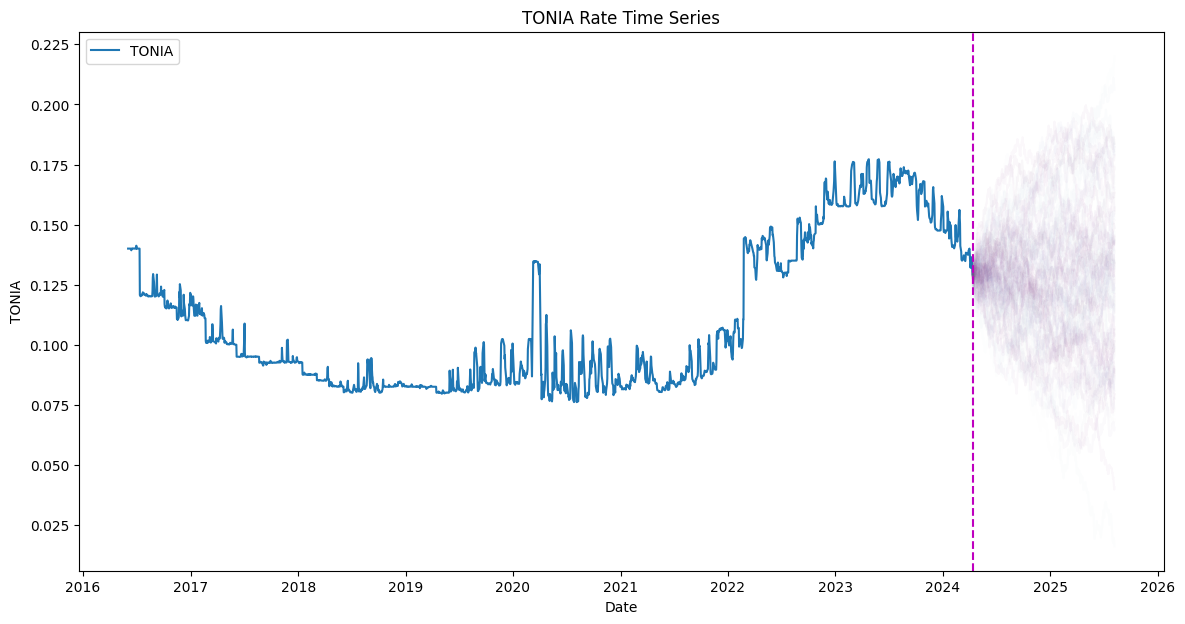

In [41]:
hwm.run_simulation(
    data=tonia_recent,
    yield_curve=ns_curve
)

## Backtesting.

Now, let's backtest our models into the history.

In [63]:
BACKTEST_START_DATES = (
    dt.datetime(2020, 1, 5),
    dt.datetime(2021, 1, 5),
    dt.datetime(2023, 1, 5)
)

First, let's create the object that will run the backtesting procedure.

In [46]:
from typing import Type, Callable, Any
from sklearn.metrics import mean_squared_error, root_mean_squared_error


class Backtester:
    def __init__(
            self,
            rate_model_cls: Type[InterestRateModel],
            yield_curve_cls: Type[YieldCurve],
            data: pd.DataFrame,
            curve_params: pd.DataFrame,
            rate_model_params: [dict[str, Any], None] = None,
            n_paths: int = 10_000,
            random_seed: [int, None] = None
    ) -> None:
        self.rate_model_cls = rate_model_cls
        self.rate_model_params = rate_model_params
        self.yield_curve_cls = yield_curve_cls

        self.data = data
        self.curve_params = curve_params

        self.n_paths = n_paths
        self.random_seed = random_seed

    @staticmethod
    def _find_closet_params(params: pd.DataFrame, date: dt.datetime) -> dict[str, float]:
        idx = np.absolute(params.index - date).argmin()
        return params.iloc[idx].to_dict()

    def backtest(
            self,
            test_start_date: dt.datetime,
            test_end_date: [dt.datetime, None] = None,
            train_start_date: [dt.datetime, None] = None
    ) -> [pd.DataFrame, pd.DataFrame]:
        if self.rate_model_params is None:
            rate_model = self.rate_model_cls(
                n_paths=self.n_paths,
                random_seed=self.random_seed
            )
        else:
            rate_model_params = self.rate_model_params.copy()
            rate_model_params["n_paths"] = self.n_paths
            rate_model_params["random_seed"] = self.random_seed
            rate_model = self.rate_model_cls(**rate_model_params)

        yield_curve = self.yield_curve_cls(**self._find_closet_params(params=self.curve_params, date=test_start_date))

        # Could modify just start_date, but this realization avoids extra indexing split
        test_end = self.data.index[-1] if test_end_date is None else test_end_date
        if train_start_date is None:
            train_data = self.data[self.data.index < test_start_date]
            test_data = self.data[(self.data.index >= test_start_date) & (self.data.index <= test_end)]
        else:
            data = self.data[self.data.index >= train_start_date]
            train_data = data[data.index < test_start_date]
            test_data = data[(data.index >= test_start_date) & (data.index <= test_end)]

        dates = pd.date_range(start=test_start_date, end=test_end, freq="1D")
        terms = tuple(((dates.shift(1) - dates).days / rate_model.CALENDAR_DAYS).to_series().cumsum().to_list())

        yield_curve.create_curve(terms=terms)
        rate_model.fit(
            data=train_data,
            yield_curve=yield_curve,
            curve_params=self.curve_params
        )

        simulated = rate_model.simulate(r0=train_data[rate_model.target_column].iloc[-1], terms=terms)
        simulated = pd.DataFrame(simulated.T, columns=[rate_model.target_column] * simulated.shape[0])

        simulated["index"] = dates
        simulated.set_index("index", inplace=True)

        return simulated, test_data.resample("1D").ffill()['close']

    def print_metrics(self, simulated: np.array, test_data: pd.Series, metric: Callable[[pd.DataFrame, pd.DataFrame], float]) -> None:
        print(f"Simulation result is {metric.__name__} = {metric(simulated.mean(axis=1), test_data) * 100:.4f}% p.a.")
        print(f"Total RMSE = {np.sqrt((simulated.mean(axis=1) - test_data.to_numpy()) ** 2).sum():.6f}")

    def run(
            self,
            test_start_date: dt.datetime,
            test_end_date: [dt.datetime, None] = None,
            train_start_date: [dt.datetime, None] = None,
            metric: Callable[[pd.DataFrame, pd.DataFrame], float] = root_mean_squared_error
    ) -> [pd.DataFrame, pd.DataFrame]:
        simulated, test_data = self.backtest(test_start_date=test_start_date, train_start_date=train_start_date,
                                             test_end_date=test_end_date)
        self.print_metrics(simulated=simulated, test_data=test_data, metric=metric)
        plot_rates(data=self.data["close"], simulated=simulated)

### Vasicek Backtest

Simulation result is root_mean_squared_error = 3.8624% p.a.
Total RMSE = 49.801344


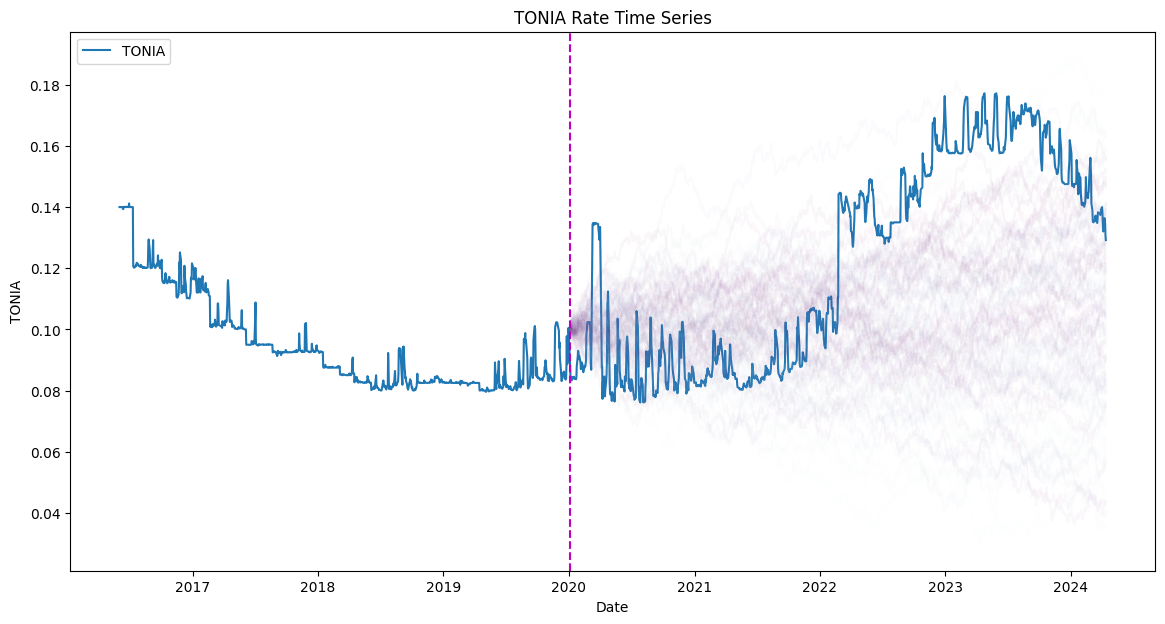

In [48]:
backtester = Backtester(
    rate_model_cls=VasicekModel,
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_recent,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
s_vs = backtester.run(test_start_date=BACKTEST_START_DATES[0])

Simulation result is root_mean_squared_error = 5.8771% p.a.
Total RMSE = 58.862566


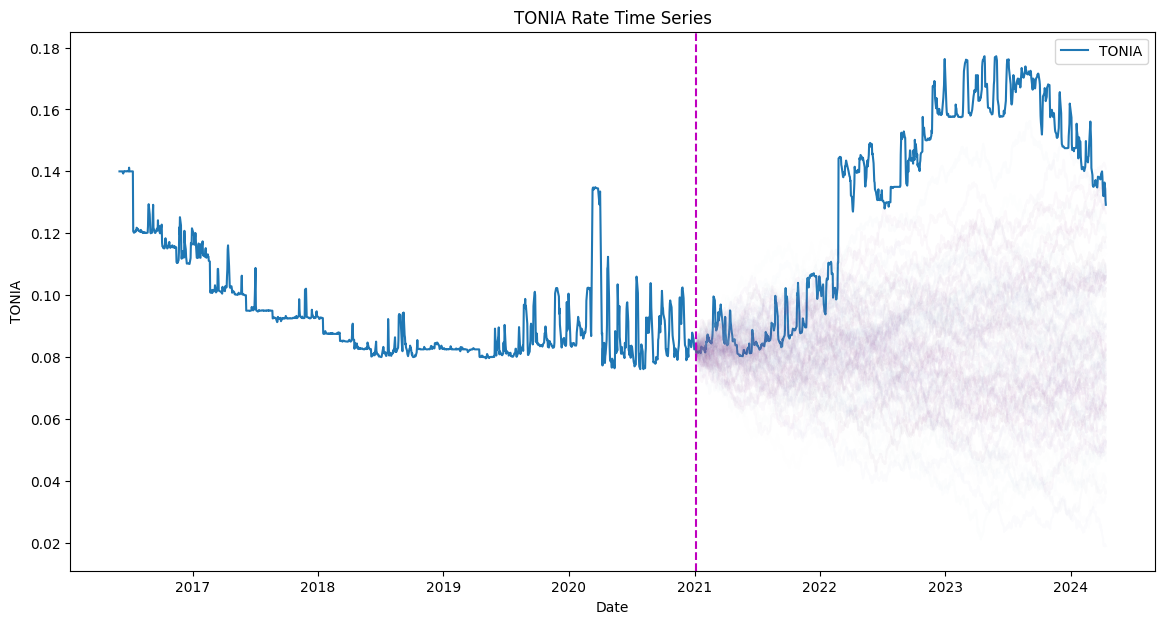

In [49]:
backtester = Backtester(
    rate_model_cls=VasicekModel,
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_recent,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
backtester.run(test_start_date=BACKTEST_START_DATES[1])

Simulation result is root_mean_squared_error = 1.0666% p.a.
Total RMSE = 3.980017


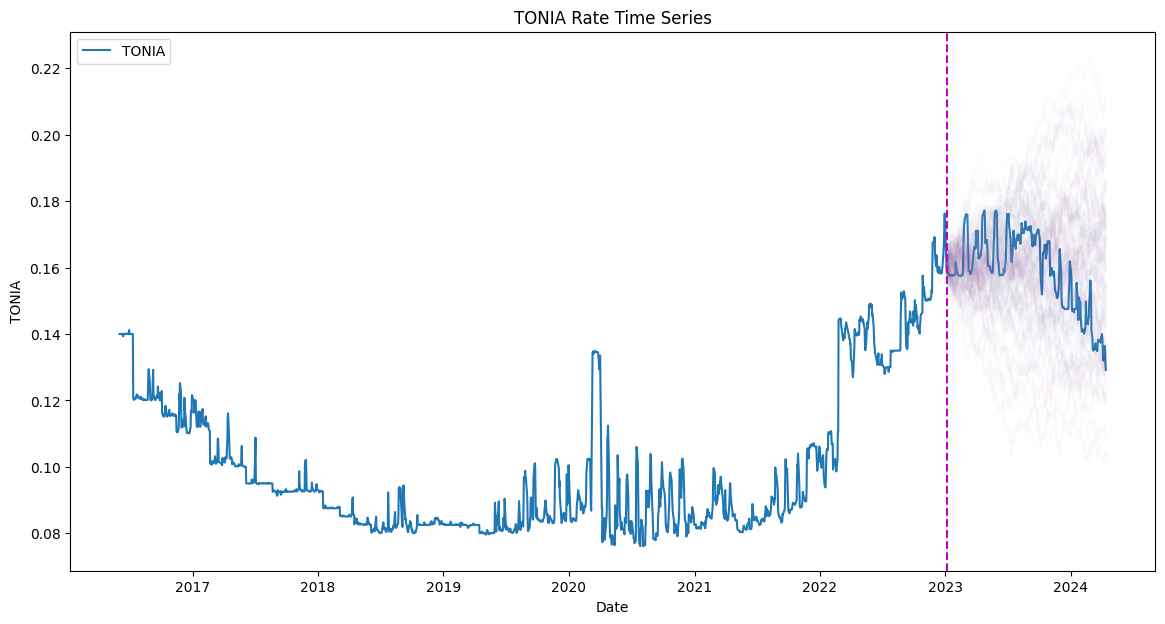

In [50]:
backtester = Backtester(
    rate_model_cls=VasicekModel,
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_recent,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
backtester.run(test_start_date=BACKTEST_START_DATES[2])

### Hull-White Backtest

Simulation result is root_mean_squared_error = 3.8624% p.a.
Total RMSE = 49.801344


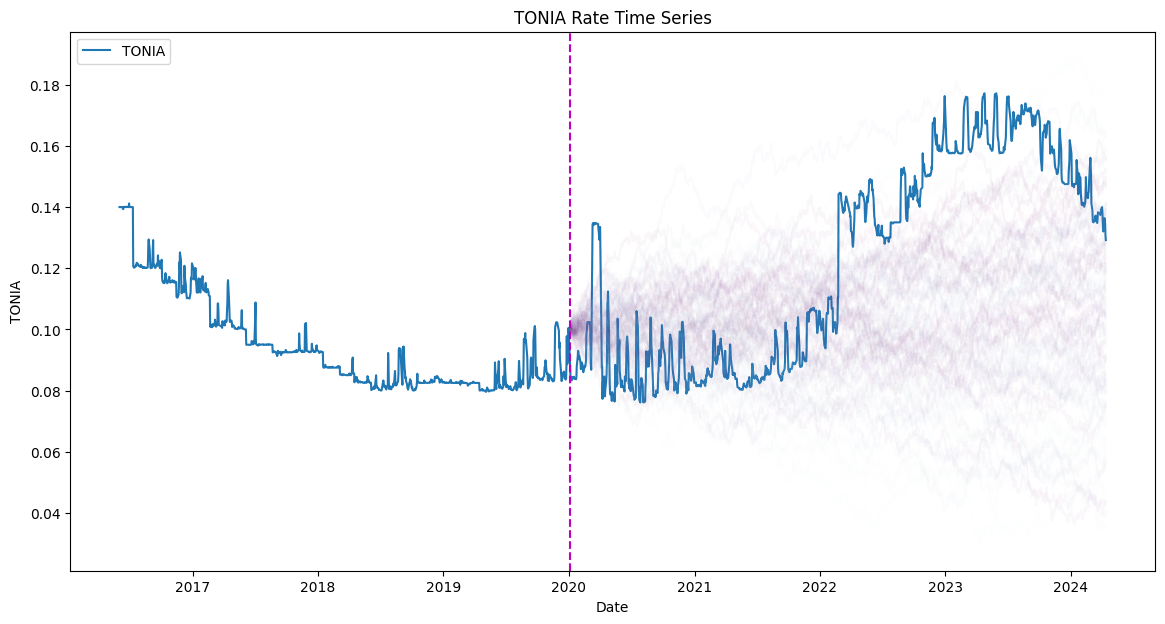

In [51]:
backtester = Backtester(
    rate_model_cls=HullWhiteModel,
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_recent,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
backtester.run(test_start_date=BACKTEST_START_DATES[0])

Simulation result is root_mean_squared_error = 5.8771% p.a.
Total RMSE = 58.862566


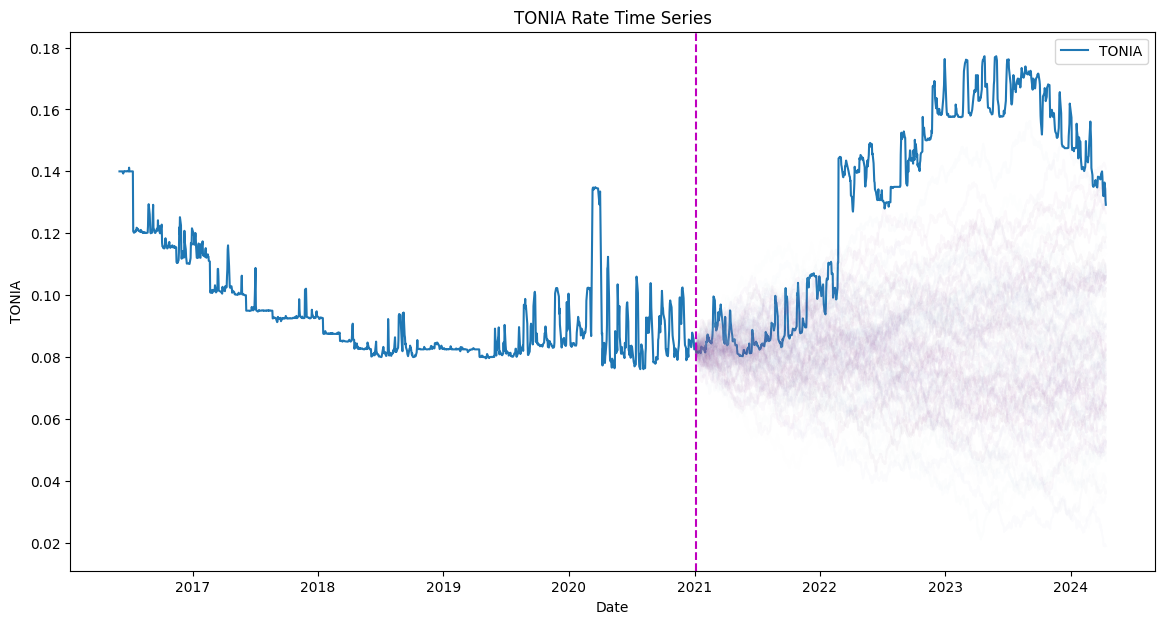

In [52]:
backtester = Backtester(
    rate_model_cls=HullWhiteModel,
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_recent,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
backtester.run(test_start_date=BACKTEST_START_DATES[1])

Simulation result is root_mean_squared_error = 1.0666% p.a.
Total RMSE = 3.980017


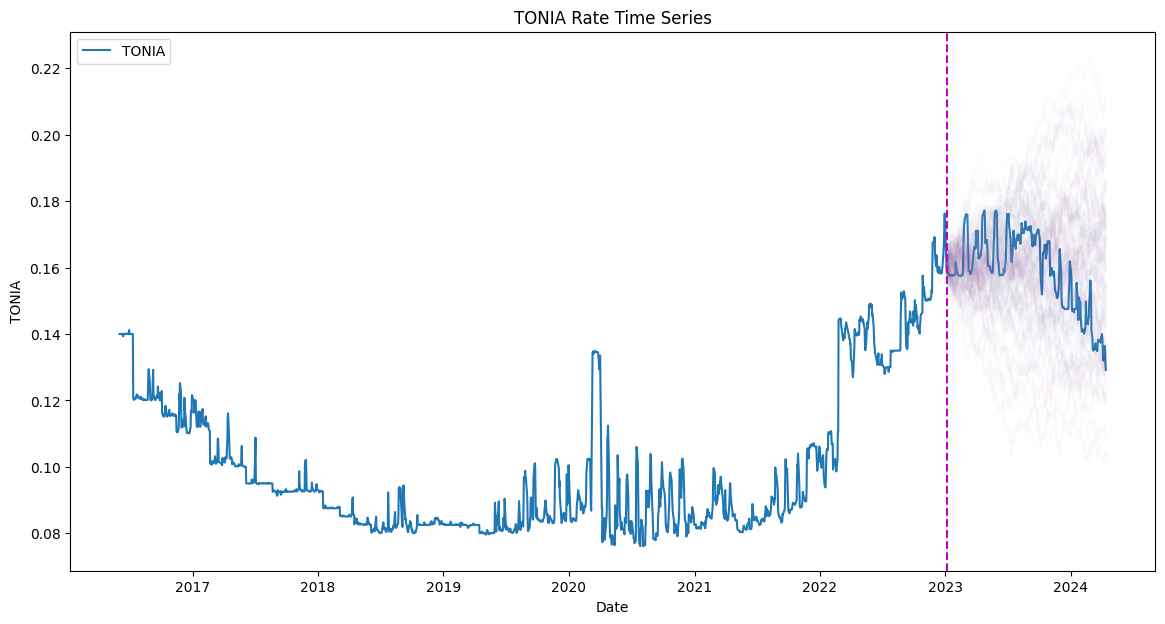

In [53]:
backtester = Backtester(
    rate_model_cls=HullWhiteModel,
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_recent,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
backtester.run(test_start_date=BACKTEST_START_DATES[2])

Backtesting data shows that for the chosen dataset Vasicek and Hull-White produce virtually same results (curves are checked - $\theta$-s are indeed different), holding same prediction power across all three chosen backtesting periods.

The result is actually an expected one - we have chosen here the overnight interest rate, which is basically affected by the realized (not implied) CB rate and the liquidity premium. As we are monitoring REPO rates via TONIA, market participants compare REPO opportunities with the CB overnight deposits / credits and auctions => place or borrow funds at current CB rate. Therefore, TONIA is affected not by the expectations of CB rate, but only by the actual level of CB rate (as even if CB rate is changed, it becomes effective next day - thus, new overnight).

Therefore, if the CB rate is not very far from the bond market participants expectations (i.e., when there is not a large lag of CB rate change that can be predicted from bond prices, but take some significant time to become realized), the long-term changes cannot be predicted from implied bond prices better than just a historical average.

The Hull-White model, though, might bring additional value for way shorter interpolations - when there might be some lag between expected and realized CB rate.

## Rolling Backtest.

Let's create a rolling backtest, where we fit the data by the historical window

In [47]:
class RollingBacktester(Backtester):
    def __init__(
            self,
            rate_model_cls: Type[InterestRateModel],
            yield_curve_cls: Type[YieldCurve],
            data: pd.DataFrame,
            curve_params: pd.DataFrame,
            rate_model_params: [dict[str, Any], None] = None,
            n_paths: int = 10_000,
            random_seed: [int, None] = None
    ) -> None:
        super().__init__(
            rate_model_cls=rate_model_cls,
            rate_model_params=rate_model_params,
            yield_curve_cls=yield_curve_cls,
            data=data,
            curve_params=curve_params,
            n_paths=n_paths,
            random_seed=random_seed
        )

    def _backtest_single(self, test_start_date: dt.datetime, test_end_date: [dt.datetime, None] = None,
                         train_start_date: [dt.datetime, None] = None) -> pd.DataFrame:
        return super().backtest(test_start_date=test_start_date, train_start_date=train_start_date,
                                test_end_date=test_end_date)

    def backtest(
            self,
            test_start_date: dt.datetime,
            predict_length: int = 5,
            is_window_fixed: bool = False,
            train_start_date: [dt.datetime, None] = None,
            *args,
            **kwargs
    ) -> [pd.DataFrame, pd.DataFrame]:
        end_date = self.data.index[-1]
        window_start_date, window_end_date = test_start_date, test_start_date + dt.timedelta(days=predict_length)
        # TODO: check that no data leak in _find_closet_params()
        simulation_full = pd.DataFrame()
        while window_end_date <= end_date:
            simulated, _ = self._backtest_single(window_start_date, window_end_date, train_start_date=train_start_date)

            window_start_date = window_end_date + dt.timedelta(days=1)
            window_end_date = window_start_date + dt.timedelta(days=predict_length)
            if is_window_fixed:
                train_start_date += dt.timedelta(days=predict_length)

            # print(simulated.mean(axis=1).iloc[0], simulated.mean(axis=1).iloc[-1])
            simulation_full = pd.concat([simulation_full, simulated], axis=0)

            assert window_start_date != simulated.index[0] and window_end_date != simulated.index[
                -1], "Dates do not match during simulation."

        test_data = self.data[(self.data.index >= test_start_date)]
        return simulation_full, test_data.resample("1D").ffill()["close"]

    def run(
            self,
            test_start_date: dt.datetime,
            test_end_date: [dt.datetime, None] = None,
            predict_length: int = 5,
            is_window_fixed: bool = False,
            train_start_date: [dt.datetime, None] = None,
            metric: Callable[[pd.DataFrame, pd.DataFrame], float] = root_mean_squared_error
    ):
        simulated, test_data = self.backtest(test_start_date=test_start_date, train_start_date=train_start_date,
                                             test_end_date=test_end_date, predict_length=predict_length,
                                             is_window_fixed=is_window_fixed)
        self.print_metrics(simulated=simulated, test_data=test_data, metric=metric)
        plot_rates(data=self.data["close"], simulated=simulated)

In [55]:
backtester = RollingBacktester(
    rate_model_cls=VasicekModel,
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_recent,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
backtester.backtest(test_start_date=dt.datetime(2020, 1, 5), predict_length=5)

(               close     close     close     close     close     close  \
 index                                                                    
 2020-01-05  0.100875  0.100504  0.101368  0.099685  0.099586  0.100082   
 2020-01-06  0.100335  0.100409  0.100406  0.100643  0.097833  0.100051   
 2020-01-07  0.100527  0.099770  0.101469  0.101040  0.096502  0.100221   
 2020-01-08  0.099180  0.102044  0.101372  0.101150  0.095086  0.099916   
 2020-01-09  0.099777  0.101571  0.102174  0.101657  0.093329  0.099715   
 ...              ...       ...       ...       ...       ...       ...   
 2024-04-08  0.131674  0.131820  0.131813  0.132282  0.126727  0.131111   
 2024-04-09  0.132053  0.130556  0.133915  0.133068  0.124094  0.131448   
 2024-04-10  0.129390  0.135053  0.133724  0.133285  0.121294  0.130846   
 2024-04-11  0.130570  0.134117  0.135309  0.134289  0.117820  0.130448   
 2024-04-12  0.128166  0.134857  0.133878  0.135114  0.116806  0.130563   
 
                close  

Simulation result is root_mean_squared_error = 0.3855% p.a.
Total RMSE = 2.993360


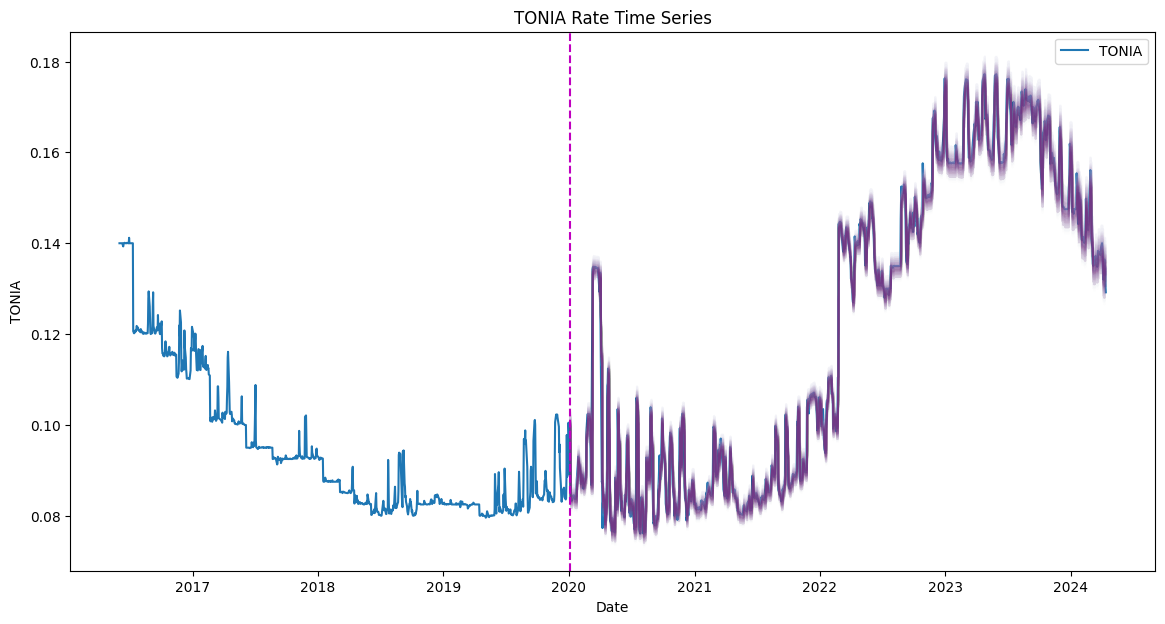

In [56]:
backtester.run(test_start_date=dt.datetime(2020, 1, 5), predict_length=1)

We can see that the Vasicek Model, refitted daily into market provides good enough (even though lagged) simulation of future rates.

## LSTM.

Let's try another idea - as the simulation is driven solely by the historical data, we can try more advanced model than AR(1) process. Let's use RNNs for fitting the data (project supposes 3 models - this is the third one).

First of all, let's create a model - it will support forward with external hidden state for simulating the sequences of rates for our rates modelling.

**Important: we will generate the Ornstein-Uhlanback process, but with neural $\theta$ and $\kappa$ in order to produce result that can be compared with Vasicek and Hull-White.**

In [48]:
SEQUENCE_LENGTH = 1


class NeuralRateLSTM(nn.Module):
    def __init__(self, input_size: int = SEQUENCE_LENGTH, hidden_size: int = 64):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTMCell(1, self.hidden_size)

        self.kappa = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 1)
        )

        self.theta = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 1)
        )

    def forward(self, rates: torch.Tensor, hidden: [(torch.Tensor), None] = None,
                predict_length: int = 1, return_hidden: bool = False) -> [torch.Tensor,
                                                                          (torch.Tensor, torch.Tensor, torch.Tensor)]:
        model_device  = rates.device
        outputs = []
        if hidden is None:
            h_t = torch.zeros(rates.size(0), self.hidden_size, dtype=torch.float32).to(model_device)
            c_t = torch.zeros(rates.size(0), self.hidden_size, dtype=torch.float32).to(model_device)
        elif len(hidden) != 2:
            raise ValueError(f"Expected two hidden state variables, got {len(hidden)}")
        else:
            h_t, c_t = hidden

        for input_t in rates.chunk(rates.size(1), dim=1):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = input_t + self.kappa(h_t) * (self.theta(h_t) - input_t)

        for _ in range(predict_length):
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = output + self.kappa(h_t) * (self.theta(h_t) - output)
            # outputs = torch.concat([outputs, output], dim=0)
            outputs.append(output)

        outputs = torch.stack(outputs, 1).squeeze(2)
        if return_hidden:
            return outputs, (h_t, c_t)
        else:
            return outputs

Let's implement custom dataset for our data.

In [49]:
from torch.utils.data import Dataset


class ToniaDataset(Dataset):
    def __init__(
            self,
            tonia: pd.DataFrame,
            target_column: str = "close",
            sequence_length: int = SEQUENCE_LENGTH
    ):
        features = tonia[[target_column]].shift(1).iloc[1:, :]
        target = tonia[target_column].iloc[1:]

        self.sequence_length = sequence_length
        self.y = torch.tensor(target.values).float()
        self.X = torch.tensor(features.values).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx: int):
        if idx >= self.sequence_length - 1:
            idx_start = idx - self.sequence_length + 1
            x = self.X[idx_start:(idx + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - idx - 1, 1)
            x = self.X[0:(idx + 1), :]
            x = torch.cat((padding, x), 0)

        return x.squeeze(1), self.y[idx].reshape(-1, 1).squeeze(1)

Further, let's provide the functions for learning (basically, we could create a class Trainer, but as usually functions are used, let's stick with them).

In [50]:
from tqdm import tqdm
from torch.utils.data import DataLoader


def train_epoch(model: nn.Module, optimizer: torch.optim.Optimizer, criterion: nn.Module,
                loader: DataLoader, tqdm_desc: str = "Model"):
    device = next(model.parameters()).device

    if tqdm_desc is None:
        iterator = loader
    else:
        iterator = tqdm(loader, desc=tqdm_desc)

    train_loss = 0.0

    model.train()
    hidden = None
    for features, labels in iterator:
        optimizer.zero_grad()

        features = features.to(device)
        pred, hidden = model(features, hidden=hidden, return_hidden=True)
        hidden = [h_t.detach() for h_t in hidden]

        loss = criterion(pred, labels.to(device))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(loader.dataset)

    return train_loss


@torch.no_grad()
def validation_epoch(model: nn.Module, criterion: nn.Module,
                     loader: DataLoader, tqdm_desc: [str, None] = None):
    device = next(model.parameters()).device

    if tqdm_desc is None:
        iterator = loader
    else:
        iterator = tqdm(loader, desc=tqdm_desc)

    val_loss = 0.0
    preds = []
    model.train()
    hidden = None
    for features, labels in iterator:
        features = features.to(device)
        pred, hidden = model(features, hidden=hidden, return_hidden=True)

        loss = criterion(pred, labels.to(device))

        val_loss += loss.item()

        preds.append(pred.detach().cpu().numpy())

    val_loss /= len(loader.dataset)

    return preds

In [51]:
from typing import Tuple, List, Optional, Any


def train(model: nn.Module, optimizer: torch.optim.Optimizer, scheduler: Optional[Any],
          train_loader: DataLoader, val_loader: DataLoader,
          num_epochs: int, print_logs: bool = True) -> Tuple[List[float], List[float]]:
    train_losses, val_losses = [], []
    criterion = nn.MSELoss()

    for epoch in range(1, num_epochs + 1):
        if print_logs:
            desc_train = f"Training {epoch}/{num_epochs}"
            desc_val = f"Validation {epoch}/{num_epochs}"
        else:
            desc_train, desc_val = None, None

        train_loss = train_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=desc_train
        )
        val_loss = validation_epoch(
            model, criterion, val_loader,
            tqdm_desc=desc_val
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        val_losses += [val_loss]

    return train_losses, val_losses

And the last realization - a wrapper that interconnects our modelling framework and deep learning procedures.

In [52]:
from functools import lru_cache

class NeuralModel(InterestRateModel):
    def __init__(self, neural_model_cls: Type[nn.Module],
                 batch_size: int = 8, n_epochs: int = 20,
                 lr: float = 1e-3,
                 target_column: str = "close", n_paths: int = 100,
                 random_seed: [int, None] = None) -> None:
        super().__init__(target_column, n_paths, random_seed)

        self.neural_model_cls = neural_model_cls
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.lr = lr

        self._dataset = None

        if torch.backends.mps.is_available():
            self.device = torch.device('mps')
        elif torch.cuda.is_available():
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')

        self._hidden = None
        self._X_y = None

    def fit_regression(self, data: pd.DataFrame, *args, **kwargs) -> None:
        self._dataset = ToniaDataset(data, target_column=self.target_column)
        self.sigma = np.std(data[self.target_column]) / np.sqrt(self.CALENDAR_DAYS)
        loader = DataLoader(self._dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)

        self.model = self.neural_model_cls().to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.n_epochs)

        train(
            model=self.model,
            optimizer=optimizer,
            scheduler=scheduler,
            train_loader=loader,
            val_loader=loader,
            num_epochs=self.n_epochs,
            print_logs=False
        )

    def simulate(self, r0: float, terms: list[float]) -> np.array:
        if self.random_seed is not None:
            np.random.seed(self.random_seed)
            torch.manual_seed(self.random_seed)

        paths = []
        for _ in range(self.n_paths):
            path = [r0]
            hidden = None
            for _ in terms:
                r_new, hidden = self.get_simulation_drift(path[-1], terms=tuple([1] * 2), hidden=hidden)
                r_new = r_new[0]
                path.append((r_new + np.random.normal(scale=self.sigma)).tolist()[0])
            paths.append(path[1:])
        return np.array(paths)

    @lru_cache(maxsize=None)
    def get_simulation_drift(self, r0: float, terms: tuple[float], hidden: [(torch.Tensor), None] = None) -> np.array:
        if hidden is None:
            if self._hidden is None or self._X_y is None:
                loader = DataLoader(self._dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)
                hidden = None
                for X, y in loader:
                    _, hidden = self.model(X.to(self.device), hidden=hidden, return_hidden=True)
                self._hidden = hidden
                self._X_y = torch.cat([X, y], dim=1)
            last = torch.cat([self._X_y, torch.Tensor([r0] * 8).reshape(-1, 1)], dim=1)[-1:, :]
            r_new, hidden = self.model(last.to(self.device), hidden=[h_t[:1, :] for h_t in self._hidden],
                                       predict_length=len(terms) - 1, return_hidden=True)
        else:
            last = torch.cat([self._X_y, torch.Tensor([r0] * 8).reshape(-1, 1)], dim=1)[-1:, :]
            r_new, hidden = self.model(last.to(self.device), hidden=hidden, predict_length=len(terms) - 1, return_hidden=True)
        r_new = r_new.detach().cpu().numpy()
        return r_new, hidden

    def fit(self, *args, **kwargs) -> None:
        self.fit_regression(*args, **kwargs)

In [62]:
neural = NeuralModel(
    neural_model_cls=NeuralRateLSTM,
    random_seed=RANDOM_SEED
)
neural.fit(tonia_recent)
neural.simulate(tonia_recent.close.iloc[-1], terms=tuple([1 / 365] * 100))

array([[0.12996767, 0.12892316, 0.12933056, ..., 0.11262529, 0.11187482,
        0.11227833],
       [0.12708604, 0.12524845, 0.12531486, ..., 0.10449782, 0.10311734,
        0.10074512],
       [0.1300218 , 0.12907593, 0.13034219, ..., 0.11568405, 0.11785866,
        0.11384585],
       ...,
       [0.12653896, 0.12795584, 0.12942658, ..., 0.12593676, 0.12546436,
        0.12420174],
       [0.13074243, 0.13165757, 0.13012615, ..., 0.10745449, 0.10670296,
        0.10439971],
       [0.12562098, 0.12673596, 0.12430075, ..., 0.10874919, 0.1087195 ,
        0.10893294]])

**Important: simulation happens autoregressively (in Vasicek and Hull-White too) - we produce a rate with some diffusion and then ask model for the new value of drift from the updated rate (so, taking into account past diffussion) and then add new diffusion.**

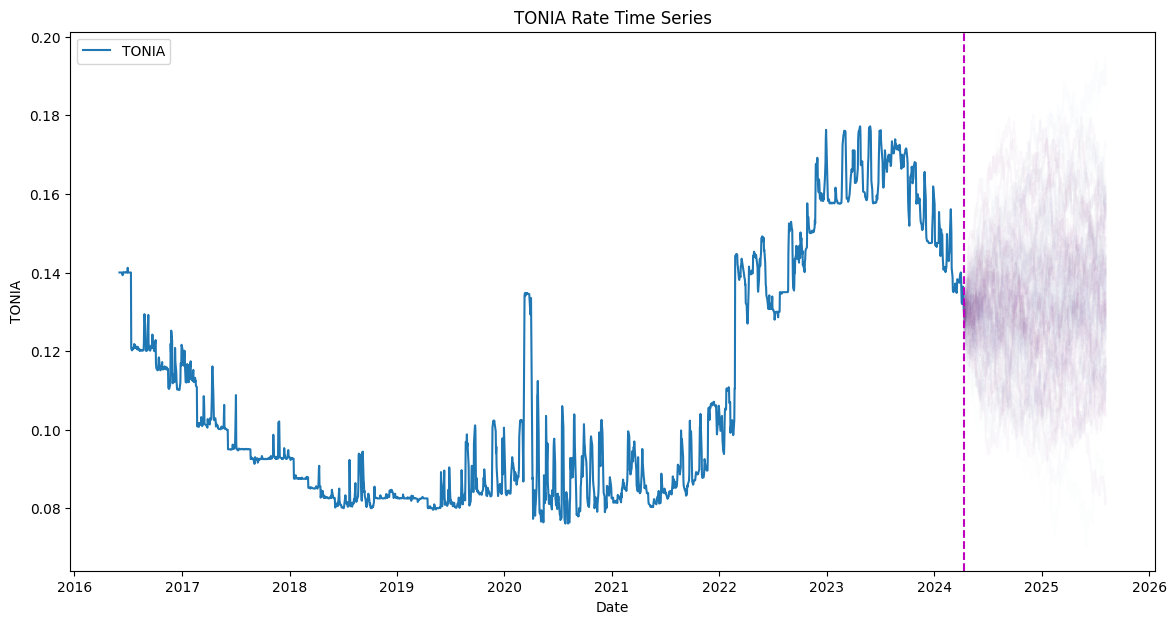

In [63]:
NeuralModel(
    neural_model_cls=NeuralRateLSTM,
    random_seed=RANDOM_SEED
).run_simulation(
    data=tonia_recent
)

Simulation result is root_mean_squared_error = 4.5560% p.a.
Total RMSE = 55.266731


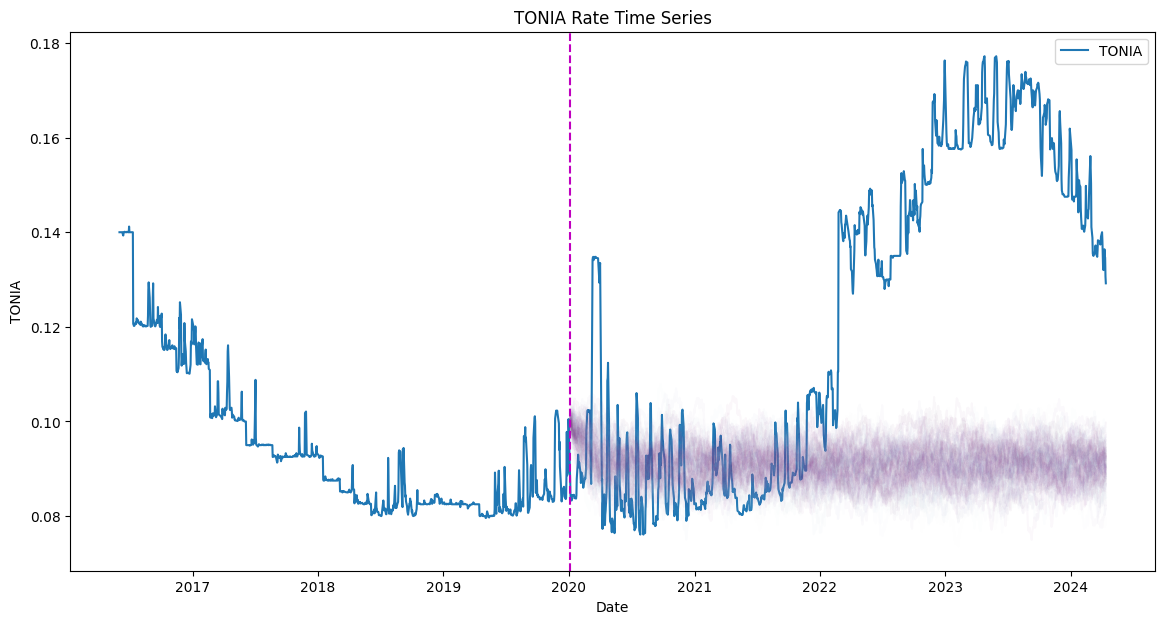

In [64]:
backtester = Backtester(
    rate_model_cls=NeuralModel,
    rate_model_params=dict(neural_model_cls=NeuralRateLSTM),
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_recent,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
backtester.run(test_start_date=BACKTEST_START_DATES[0])

Simulation result is root_mean_squared_error = 5.0946% p.a.
Total RMSE = 50.691954


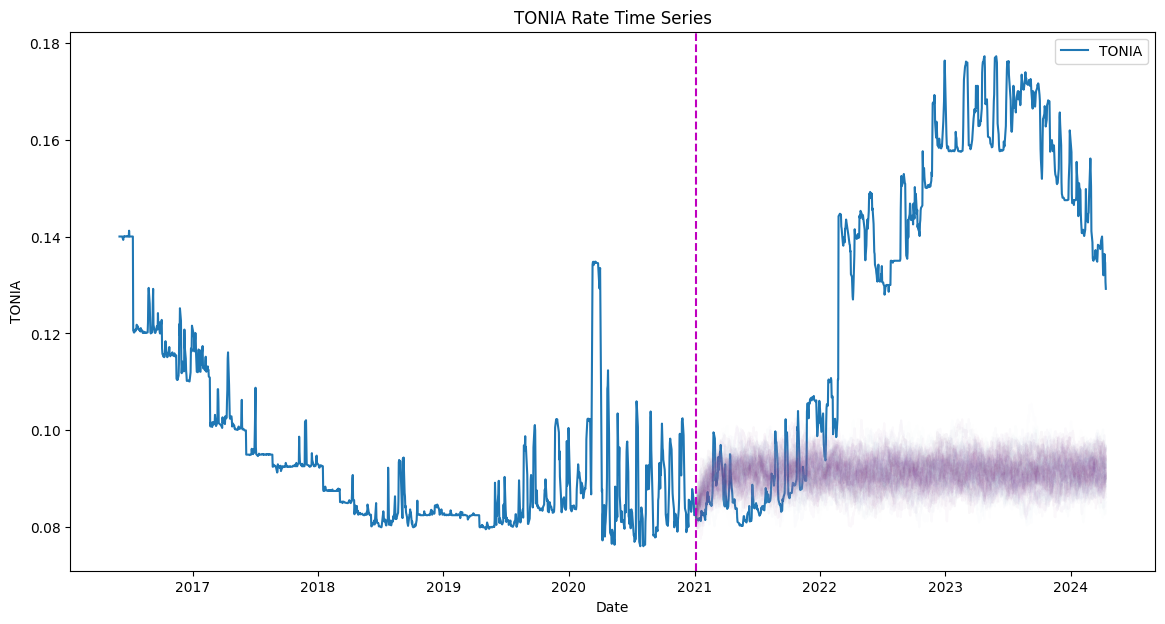

In [65]:
backtester = Backtester(
    rate_model_cls=NeuralModel,
    rate_model_params=dict(neural_model_cls=NeuralRateLSTM),
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_recent,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
backtester.run(test_start_date=BACKTEST_START_DATES[1])

Simulation result is root_mean_squared_error = 3.3104% p.a.
Total RMSE = 14.146052


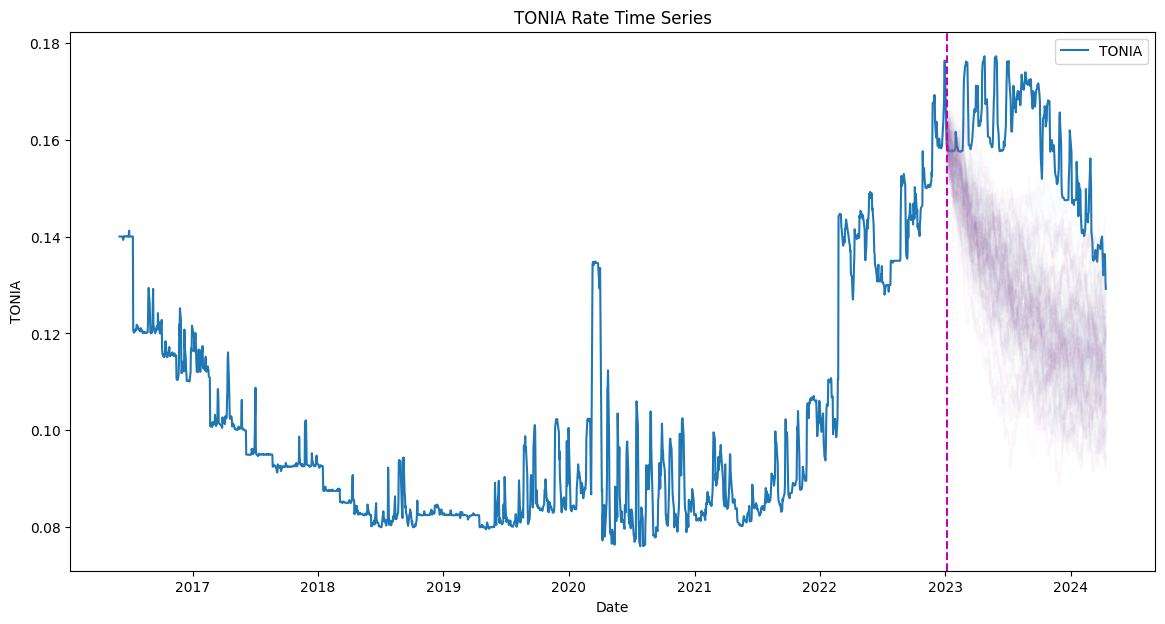

In [66]:
backtester = Backtester(
    rate_model_cls=NeuralModel,
    rate_model_params=dict(neural_model_cls=NeuralRateLSTM),
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_recent,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
backtester.run(test_start_date=BACKTEST_START_DATES[2])

Here we get very thrilling results - even though the LSTM is worse (!) than Vasicek in 2/3 backtesting periods, it actually underperformes, where Vasicek is very precise, but where Vasicek and Hull-White simulate poorly, LSTM fits better. Therefore, this model is capable of more general estimations and simulations, but usually predicts faster changes than actually happened.

### Long-Term Memory Check.

Let's check another fact - as LSTM was created to be able to keep memory of some long-term events, while AR(1) process in Vasicek/Hull-White is known to "forget" rather quickly, we can check what would happen, if we use the large dataset with outliers present.

Simulation result is root_mean_squared_error = 0.9353% p.a.
Total RMSE = 3.424184


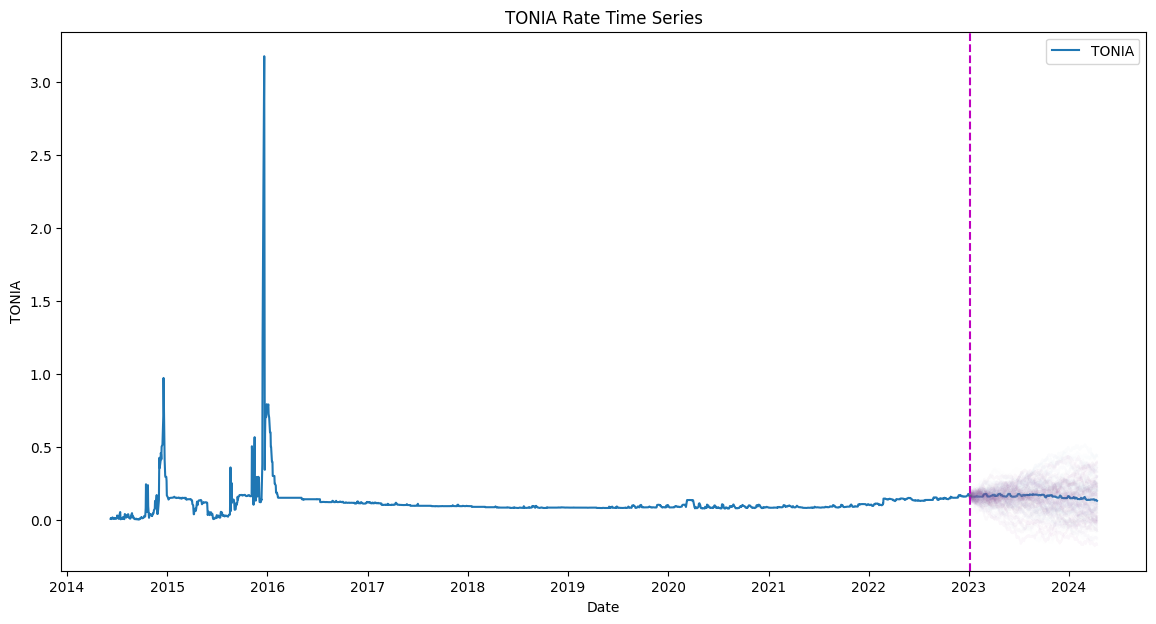

In [67]:
backtester = Backtester(
    rate_model_cls=VasicekModel,
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_df,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
backtester.run(test_start_date=dt.datetime(2023, 1, 5))

Simulation result is root_mean_squared_error = 0.9353% p.a.
Total RMSE = 3.424184


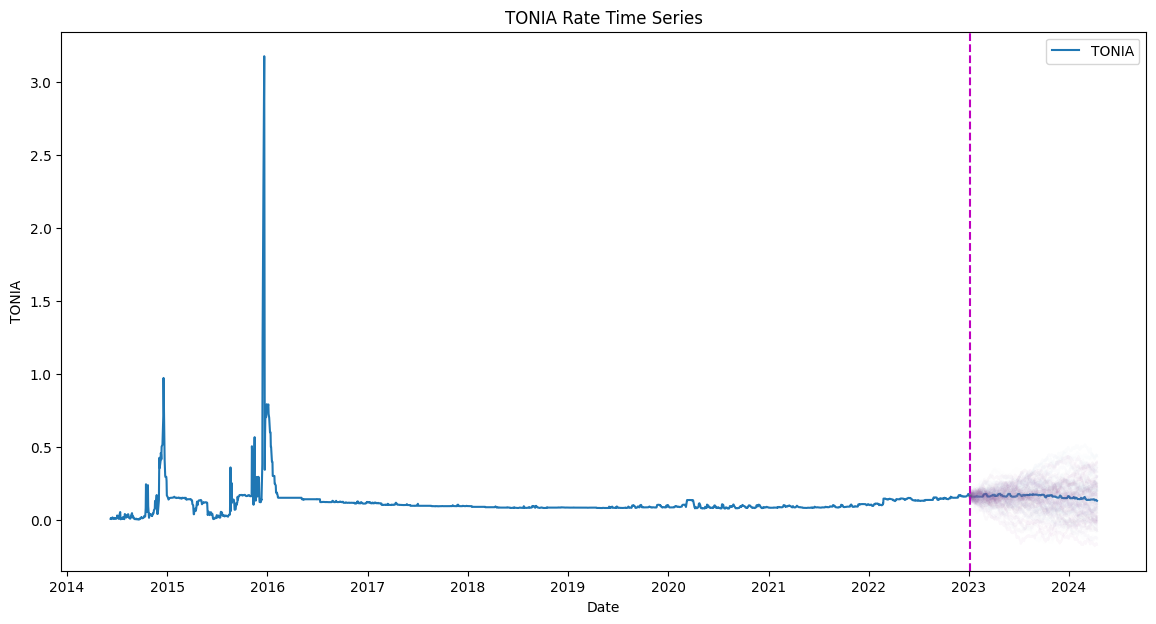

In [68]:
backtester = Backtester(
    rate_model_cls=HullWhiteModel,
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_df,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
backtester.run(test_start_date=dt.datetime(2023, 1, 5))

Simulation result is root_mean_squared_error = 64.0009% p.a.
Total RMSE = 163.401928


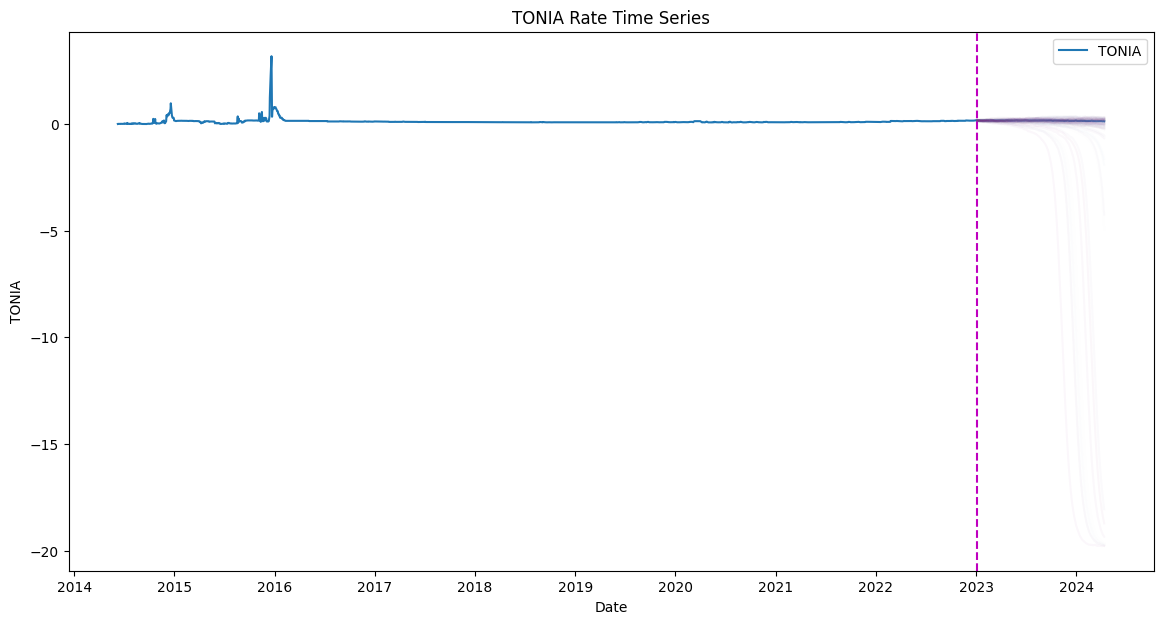

In [69]:
backtester = Backtester(
    rate_model_cls=NeuralModel,
    rate_model_params=dict(neural_model_cls=NeuralRateLSTM),
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_df,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
backtester.run(test_start_date=dt.datetime(2023, 1, 5))

Here we can see that while Vasicek and Hull-White are (similarly) robust, the LSTM overfits to the spike and produces predicts of spike during autoregressive simulation (when rate randomly goes down, LSTM drives it lower and lower).

## Simple RNN.

Maybe the problem is LSTM that uses too much memory and is more likely to overfit? Let's try simple RNN, using all the same framework.

In [70]:
SEQUENCE_LENGTH = 1


class NeuralRateRNN(nn.Module):
    def __init__(self, input_size: int = SEQUENCE_LENGTH, hidden_size: int = 64):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn = nn.RNNCell(1, self.hidden_size)

        self.kappa = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 1)
        )

        self.theta = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 1)
        )

    def forward(self, rates: torch.Tensor, hidden: [(torch.Tensor), None] = None,
                predict_length: int = 1, return_hidden: bool = False) -> [torch.Tensor,
                                                                          (torch.Tensor, torch.Tensor, torch.Tensor)]:
        model_device  = rates.device
        outputs = []
        if hidden is None:
            h_t = torch.zeros(rates.size(0), self.hidden_size, dtype=torch.float32).to(model_device)
        elif len(hidden) != 1:
            raise ValueError(f"Expected one hidden state variable, got {len(hidden)}")
        else:
            h_t, = hidden

        for input_t in rates.chunk(rates.size(1), dim=1):
            h_t = self.rnn(input_t, h_t)
            output = input_t + self.kappa(h_t) * (self.theta(h_t) - input_t)

        for _ in range(predict_length):
            h_t = self.rnn(input_t, h_t)
            output = output + self.kappa(h_t) * (self.theta(h_t) - output)
            # outputs = torch.concat([outputs, output], dim=0)
            outputs.append(output)

        outputs = torch.stack(outputs, 1).squeeze(2)
        if return_hidden:
            return outputs, (h_t,)
        else:
            return outputs

Simulation result is root_mean_squared_error = 4.6101% p.a.
Total RMSE = 55.737751


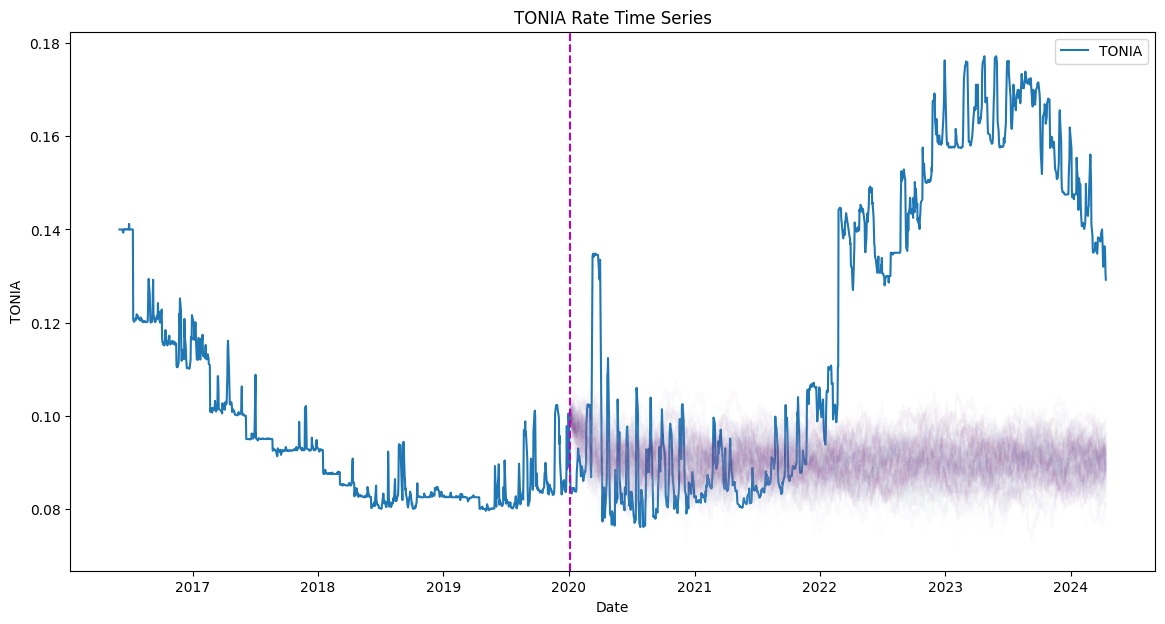

In [71]:
backtester = Backtester(
    rate_model_cls=NeuralModel,
    rate_model_params=dict(neural_model_cls=NeuralRateRNN),
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_recent,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
backtester.run(test_start_date=BACKTEST_START_DATES[0])

Simulation result is root_mean_squared_error = 5.1173% p.a.
Total RMSE = 50.885903


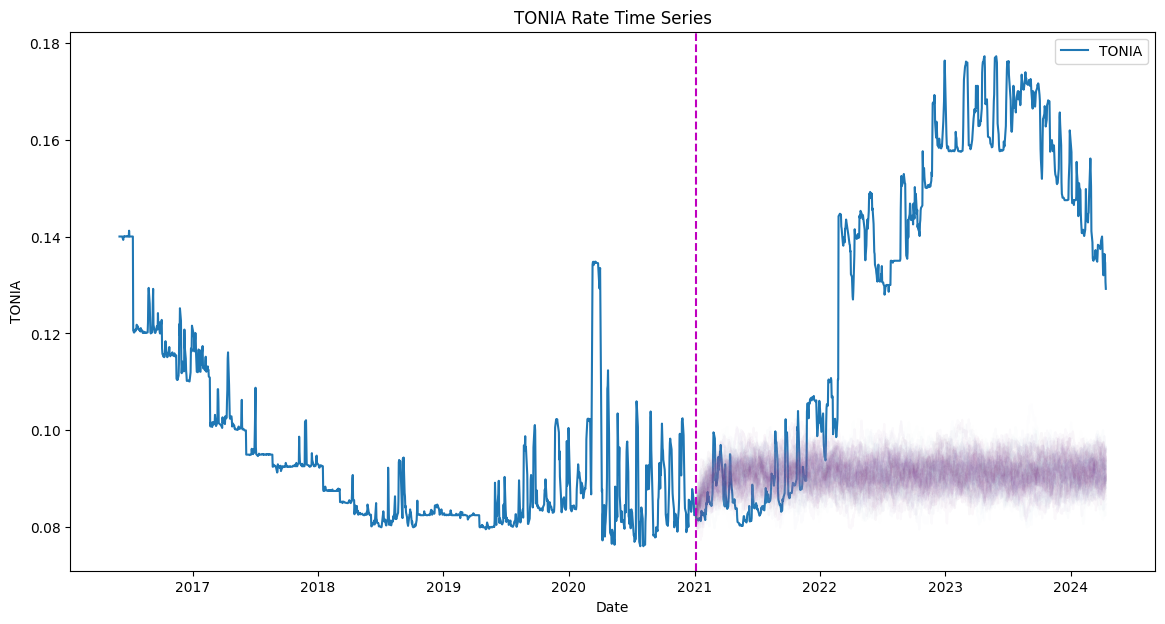

In [72]:
backtester = Backtester(
    rate_model_cls=NeuralModel,
    rate_model_params=dict(neural_model_cls=NeuralRateRNN),
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_recent,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
backtester.run(test_start_date=BACKTEST_START_DATES[1])

Simulation result is root_mean_squared_error = 4.0935% p.a.
Total RMSE = 17.750434


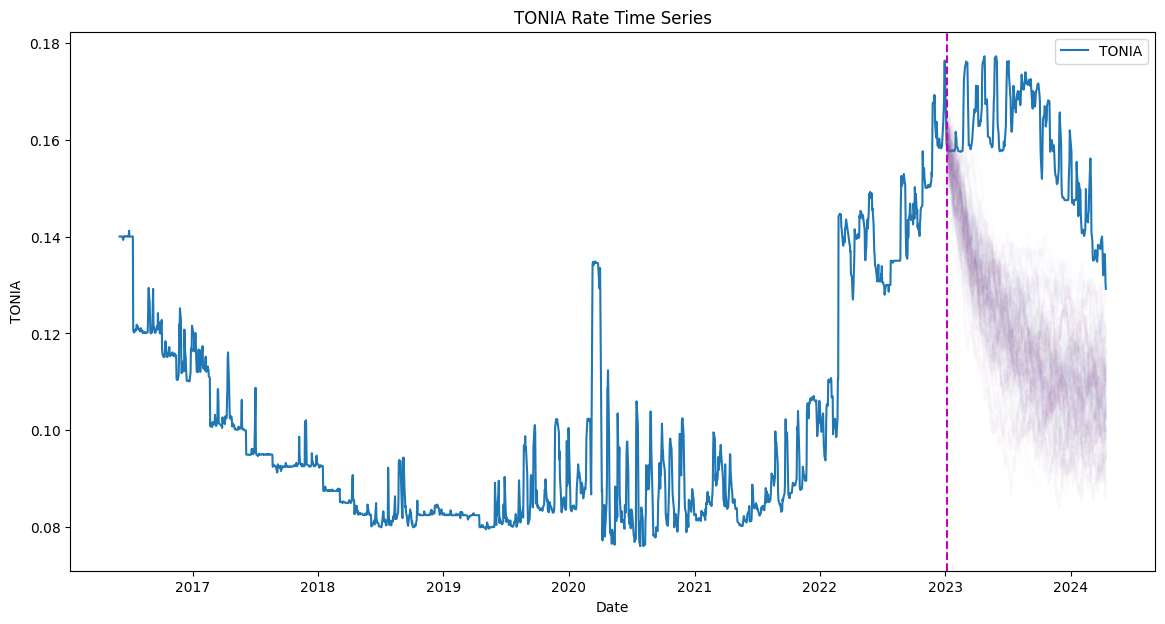

In [73]:
backtester = Backtester(
    rate_model_cls=NeuralModel,
    rate_model_params=dict(neural_model_cls=NeuralRateRNN),
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_recent,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
backtester.run(test_start_date=BACKTEST_START_DATES[2])

RNN results are slightly worse than LSTM's - thus, the problem not in the memory and LSTM seems to be good enough choice.

## Adding instantaneous forward curve to neural model.

Finally, let's use the idea from Hull-White - telling the model about future expectations from the spot curve. We could calibrate to the curve - use Hull-White Logic + RNN/LSTM kappa, but as Vasicek works better than LSTM, there is not much potential value in that.

Let's go another way - add new backbone for curve parameters estimation. Let's use the curve, not NSS parameters - there is a risk of overfitting, but such an approach is generalized under another curve interpolations (and actual discrete curves too).

In [53]:
CURVE_TERMS_LEN = 101


class ToniaDatasetCalibrated(Dataset):
    def __init__(
            self,
            tonia: pd.DataFrame,
            curve_params: pd.DataFrame,
            yield_curve_cls: Type[YieldCurve] = NelsonSiegelCurve,
            target_column: str = "close",
            sequence_length: int = SEQUENCE_LENGTH,
            curve_terms_len: int = CURVE_TERMS_LEN
    ):
        features = tonia[[target_column]].shift(1).iloc[1:, :]
        target = tonia[target_column].iloc[1:]

        self.sequence_length = sequence_length
        self.y = torch.tensor(target.values).float()
        self.X = torch.tensor(features.values).float()

        curves = []
        for date in tonia.index:
            yield_curve = yield_curve_cls(**self._find_closet_params(params=curve_params, date=date))
            yield_curve.create_curve(terms=np.linspace(1 / 365, 25., curve_terms_len + 1))
            curves.append(torch.Tensor(yield_curve.instant_fwd_rate.to_numpy()).float())
        self.curves = torch.stack(curves).squeeze(2)

    @staticmethod
    def _find_closet_params(params: pd.DataFrame, date: dt.datetime) -> dict[str, float]:
        idx = np.absolute(params.index - date).argmin()
        return params.iloc[idx].to_dict()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx: int):
        if idx >= self.sequence_length - 1:
            idx_start = idx - self.sequence_length + 1
            x = self.X[idx_start:(idx + 1), :]
            c = self.curves[idx_start:(idx + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - idx - 1, 1)
            x = self.X[0:(idx + 1), :]
            x = torch.cat((padding, x), 0)

            padding = self.curves[0].repeat(self.sequence_length - idx - 1, 1)
            c = self.curves[0:(idx + 1), :]
            c = torch.cat((padding, c), 0)

        return x.squeeze(1), c.squeeze(1), self.y[idx].reshape(-1, 1).squeeze(1)

In [54]:
dataset = ToniaDatasetCalibrated(tonia_recent, ns_curve_params)
dataset[0]

(tensor([0.1400]),
 tensor([[0.1012, 0.0994, 0.0916, 0.0884, 0.0875, 0.0872, 0.0871, 0.0871, 0.0871,
          0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871,
          0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871,
          0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871,
          0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871,
          0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871,
          0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871,
          0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871,
          0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871,
          0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871,
          0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871, 0.0871,
          0.0871, 0.0871]]),
 tensor([0.1400]))

In [55]:
dataset.curves.shape

torch.Size([1934, 101])

In [56]:
loader = DataLoader(dataset, shuffle=False, batch_size=1)
for X, curves, y in loader:
    print(X.shape, curves.shape)
    break

torch.Size([1, 1]) torch.Size([1, 1, 101])


In [57]:
class NeuralRateCalibrated(nn.Module):
    def __init__(self, input_size: int = SEQUENCE_LENGTH, curve_terms: int = CURVE_TERMS_LEN, hidden_size: int = 64):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rates_lstm = nn.LSTMCell(1, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, 1)

        self.curve_lstm = nn.LSTMCell(curve_terms, self.hidden_size)

        self.kappa = nn.Sequential(
            nn.Linear(2 * self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 1)
        )

        self.theta = nn.Sequential(
            nn.Linear(2 * self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 1)
        )

    def forward(self, rates: torch.Tensor, curves: torch.Tensor, h_t_rates: [torch.Tensor, None] = None,
                c_t_rates: [torch.Tensor, None] = None, h_t_curves: [torch.Tensor, None] = None,
                c_t_curves: [torch.Tensor, None] = None,
                predict_length: int = 1, return_hidden: bool = False) -> [torch.Tensor,
                                                                          (torch.Tensor, torch.Tensor, torch.Tensor)]:
        model_device  = rates.device
        outputs = []

        if h_t_rates is None:
            h_t_rates = torch.zeros(rates.size(0), self.hidden_size, dtype=torch.float32).to(model_device)
        if c_t_rates is None:
            c_t_rates = torch.zeros(rates.size(0), self.hidden_size, dtype=torch.float32).to(model_device)

        if h_t_curves is None:
            h_t_curves = torch.zeros(rates.size(0), self.hidden_size, dtype=torch.float32).to(model_device)
        if c_t_curves is None:
            c_t_curves = torch.zeros(rates.size(0), self.hidden_size, dtype=torch.float32).to(model_device)

        for rates_t, curve_t in zip(rates.chunk(rates.size(1), dim=1), curves.chunk(curves.size(1), dim=1)):
            curve_t = curve_t.squeeze(1)
            h_t_rates, c_t_rates = self.rates_lstm(rates_t, (h_t_rates, c_t_rates))
            h_t_curves, c_t_curves = self.curve_lstm(curve_t, (h_t_curves, c_t_curves))

            h_t = torch.cat((h_t_rates, h_t_curves), dim=1)
            output = self.kappa(h_t) * (self.theta(h_t) - rates_t)

        for _ in range(predict_length):
            h_t_rates, c_t_rates = self.rates_lstm(output, (h_t_rates, c_t_rates))
            h_t_curves, c_t_curves = self.curve_lstm(curve_t, (h_t_curves, c_t_curves))

            h_t = torch.cat((h_t_rates, h_t_curves), dim=1)
            output = self.kappa(h_t) * (self.theta(h_t) - output)
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        if return_hidden:
            return outputs, h_t_rates, c_t_rates, h_t_curves, c_t_curves
        else:
            return outputs

In [58]:
def train_epoch_calibrated(model: nn.Module, optimizer: torch.optim.Optimizer, criterion: nn.Module,
                           loader: DataLoader, tqdm_desc: str = "G-Spread Model"):
    device = next(model.parameters()).device

    if tqdm_desc is None:
        iterator = loader
    else:
        iterator = tqdm(loader, desc=tqdm_desc)

    train_loss = 0.0

    model.train()
    h_t_rates, c_t_rates = None, None
    h_t_curves, c_t_curves = None, None
    for rates, curves, labels in iterator:
        optimizer.zero_grad()

        rates = rates.to(device)
        curves = curves.to(device)
        pred, h_t_rates, c_t_rates, h_t_curves, c_t_curves = model(rates, curves, h_t_rates=h_t_rates, c_t_rates=c_t_rates,
                                                                   h_t_curves=h_t_curves, c_t_curves=c_t_curves,
                                                                   return_hidden=True)
        h_t_rates, c_t_rates, h_t_curves, c_t_curves = h_t_rates.detach(), c_t_rates.detach(), h_t_curves.detach(), c_t_curves.detach()

        loss = criterion(pred, labels.to(device))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(loader.dataset)

    return train_loss


@torch.no_grad()
def validation_epoch_calibrated(model: nn.Module, criterion: nn.Module,
                                loader: DataLoader, tqdm_desc: [str, None] = None):
    device = next(model.parameters()).device

    if tqdm_desc is None:
        iterator = loader
    else:
        iterator = tqdm(loader, desc=tqdm_desc)

    val_loss = 0.0
    preds = []
    model.train()
    h_t_rates, c_t_rates = None, None
    h_t_curves, c_t_curves = None, None
    for rates, curves, labels in iterator:
        rates = rates.to(device)
        curves = curves.to(device)
        pred, h_t_rates, c_t_rates, h_t_curves, c_t_curves = model(rates, curves, h_t_rates=h_t_rates, c_t_rates=c_t_rates,
                                                                   h_t_curves=h_t_curves, c_t_curves=c_t_curves,
                                                                   return_hidden=True)

        loss = criterion(pred, labels.to(device))

        val_loss += loss.item()

        preds.append(pred.detach().cpu().numpy())

    val_loss /= len(loader.dataset)

    return preds


def train_calibrated(model: nn.Module, optimizer: torch.optim.Optimizer, scheduler: Optional[Any],
                     train_loader: DataLoader, val_loader: DataLoader,
                     num_epochs: int, print_logs: bool = True) -> Tuple[List[float], List[float]]:
    train_losses, val_losses = [], []
    criterion = nn.MSELoss()

    for epoch in range(1, num_epochs + 1):
        if print_logs:
            desc_train = f"Training {epoch}/{num_epochs}"
            desc_val = f"Validation {epoch}/{num_epochs}"
        else:
            desc_train, desc_val = None, None

        train_loss = train_epoch_calibrated(
            model, optimizer, criterion, train_loader,
            tqdm_desc=desc_train
        )
        val_loss = validation_epoch_calibrated(
            model, criterion, val_loader,
            tqdm_desc=desc_val
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        val_losses += [val_loss]

    return train_losses, val_losses

In [59]:
class NeuralModelCalibrated(InterestRateModel):
    def __init__(self, neural_model_cls: Type[nn.Module] = NeuralRateCalibrated, batch_size: int = 8, n_epochs: int = 20,
                 lr: float = 1e-3,
                 target_column: str = "close", n_paths: int = 100,
                 random_seed: [int, None] = None) -> None:
        super().__init__(target_column, n_paths, random_seed)

        self.neural_model_cls = neural_model_cls
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.lr = lr

        self._dataset = None

        if torch.backends.mps.is_available():
            self.device = torch.device('mps')
        elif torch.cuda.is_available():
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')

        self._h_t_rates, self._c_t_rates = None, None
        self._h_t_curves, self._c_t_curves = None, None

        self._X_y = None
        self._curves = None

    def fit_regression(self, data: pd.DataFrame, curve_params: pd.DataFrame, *args, **kwargs) -> None:
        self._dataset = ToniaDatasetCalibrated(data, curve_params, target_column=self.target_column)
        self.sigma = np.std(data[self.target_column]) / np.sqrt(self.CALENDAR_DAYS)
        loader = DataLoader(self._dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)

        self.model = self.neural_model_cls().to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.n_epochs)

        train_calibrated(
            model=self.model,
            optimizer=optimizer,
            scheduler=scheduler,
            train_loader=loader,
            val_loader=loader,
            num_epochs=self.n_epochs,
            print_logs=False
        )

    def simulate(self, r0: float, terms: list[float]) -> np.array:
        if self.random_seed is not None:
            np.random.seed(self.random_seed)
            torch.manual_seed(self.random_seed)

        paths = []
        for _ in range(self.n_paths):
            path = [r0]
            h_t_rates, c_t_rates = None, None
            h_t_curves, c_t_curves = None, None
            for _ in terms:
                r_new, h_t_rates, c_t_rates, h_t_curves, c_t_curves = self.get_simulation_drift(path[-1], terms=tuple([1] * 2),
                                                                        h_t_rates=h_t_rates,
                                                                        c_t_rates=c_t_rates,
                                                                        h_t_curves=h_t_curves,
                                                                        c_t_curves=c_t_curves)
                r_new = r_new[0]
                path.append((r_new + np.random.normal(scale=self.sigma)).tolist()[0])
            paths.append(path[1:])
        return np.array(paths)

    @lru_cache(maxsize=None)
    def get_simulation_drift(self, r0: float, terms: tuple[float],
                             h_t_rates: [torch.Tensor, None] = None,
                             c_t_rates: [torch.Tensor, None] = None,
                             h_t_curves: [torch.Tensor, None] = None,
                             c_t_curves: [torch.Tensor, None] = None) -> np.array:
        if h_t_rates is None or c_t_rates is None or h_t_curves is None or c_t_curves is None:
            if self._h_t_rates is None or self._c_t_rates is None or self._h_t_curves is None or self._c_t_curves is None or self._X_y is None:
                loader = DataLoader(self._dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)
                h_t_rates, c_t_rates = None, None
                h_t_curves, c_t_curves = None, None
                for X, curves, y in loader:
                    _, h_t_rates, c_t_rates, h_t_curves, c_t_curves = self.model(X.to(self.device),
                                                                                 curves.to(self.device),
                                                                                 h_t_rates=h_t_rates,
                                                                                 c_t_rates=c_t_rates,
                                                                                 h_t_curves=h_t_curves,
                                                                                 c_t_curves=c_t_curves,
                                                                                 return_hidden=True)
                self._h_t_rates, self._c_t_rates = h_t_rates, c_t_rates
                self._h_t_curves, self._c_t_curves = h_t_curves, c_t_curves
                self._X_y = torch.cat([X, y], dim=1)
                self._curves = curves.to(self.device)
            last = torch.cat([self._X_y, torch.Tensor([r0] * 8).reshape(-1, 1)], dim=1)[-1, :]
            r_new, h_t_rates, c_t_rates, h_t_curves, c_t_curves = self.model(last.unsqueeze(0).to(self.device),
                                                                             self._curves[-1:, :],
                                                                             h_t_rates=self._h_t_rates[:1, :],
                                                                             c_t_rates=self._c_t_rates[:1, :],
                                                                             h_t_curves=self._h_t_curves[:1, :],
                                                                             c_t_curves=self._c_t_curves[:1, :],
                                         predict_length=len(terms) - 1, return_hidden=True)
        else:
            last = torch.cat([self._X_y, torch.Tensor([r0] * 8).reshape(-1, 1)], dim=1)[-1, :]
            r_new, h_t_rates, c_t_rates, h_t_curves, c_t_curves = self.model(last.unsqueeze(0).to(self.device),
                                                                             self._curves[-1:, :],
                                                                             h_t_rates=h_t_rates,
                                                                             c_t_rates=c_t_rates,
                                                                             h_t_curves=h_t_curves,
                                                                             c_t_curves=c_t_curves,
                                         predict_length=len(terms) - 1, return_hidden=True)

        r_new = r_new.detach().cpu().numpy()
        return r_new, h_t_rates, c_t_rates, h_t_curves, c_t_curves

    def fit(self, *args, **kwargs) -> None:
        self.fit_regression(*args, **kwargs)

In [60]:
neural_c = NeuralModelCalibrated(random_seed=RANDOM_SEED)
neural_c.fit(data=tonia_recent, curve_params=ns_curve_params)
neural_c.simulate(tonia_recent.close.iloc[-1], terms=tuple([1 / 365] * 100))

array([[0.11767878, 0.11586668, 0.117314  , ..., 0.11466698, 0.11609301,
        0.11724402],
       [0.11479715, 0.11506263, 0.11695901, ..., 0.11750963, 0.11543079,
        0.11443356],
       [0.1177329 , 0.1159655 , 0.11817342, ..., 0.11747706, 0.11903004,
        0.11285108],
       ...,
       [0.11425007, 0.11831503, 0.11837366, ..., 0.11647918, 0.11642263,
        0.11563059],
       [0.11845354, 0.11782924, 0.11538551, ..., 0.11640101, 0.11607153,
        0.11451682],
       [0.11333209, 0.11800963, 0.11446306, ..., 0.11678356, 0.11679848,
        0.1170415 ]])

In [61]:
neural_c._curves.shape

torch.Size([8, 1, 101])

Simulation result is root_mean_squared_error = 4.5152% p.a.
Total RMSE = 54.707512


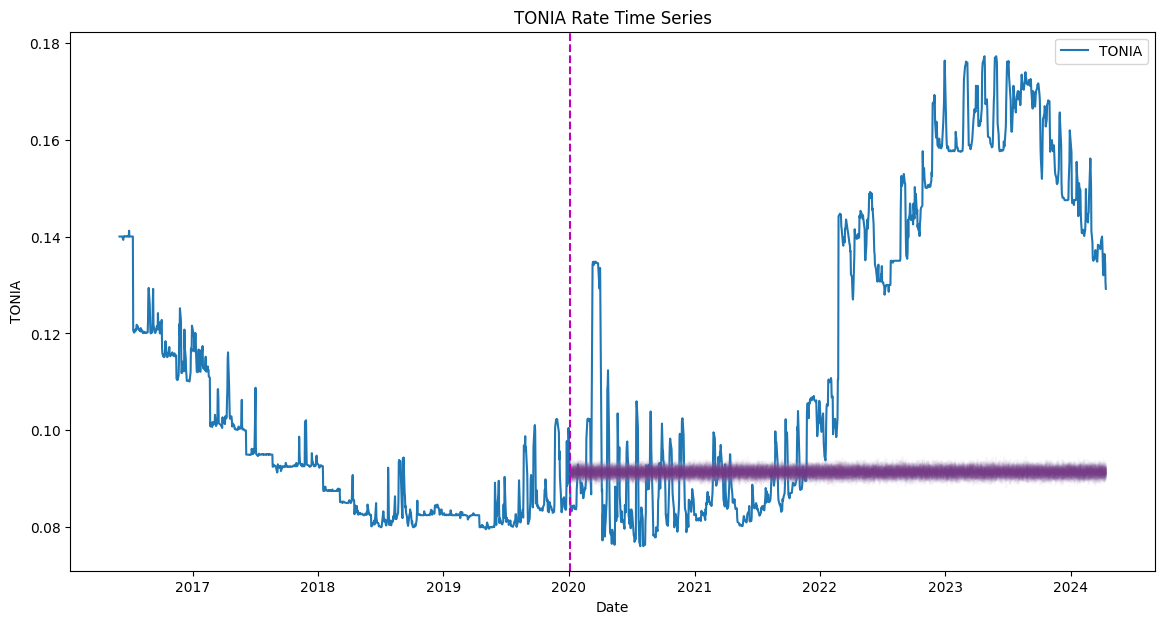

In [65]:
backtester = Backtester(
    rate_model_cls=NeuralModelCalibrated,
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_recent,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
backtester.run(test_start_date=BACKTEST_START_DATES[0])

Simulation result is root_mean_squared_error = 5.1488% p.a.
Total RMSE = 51.360209


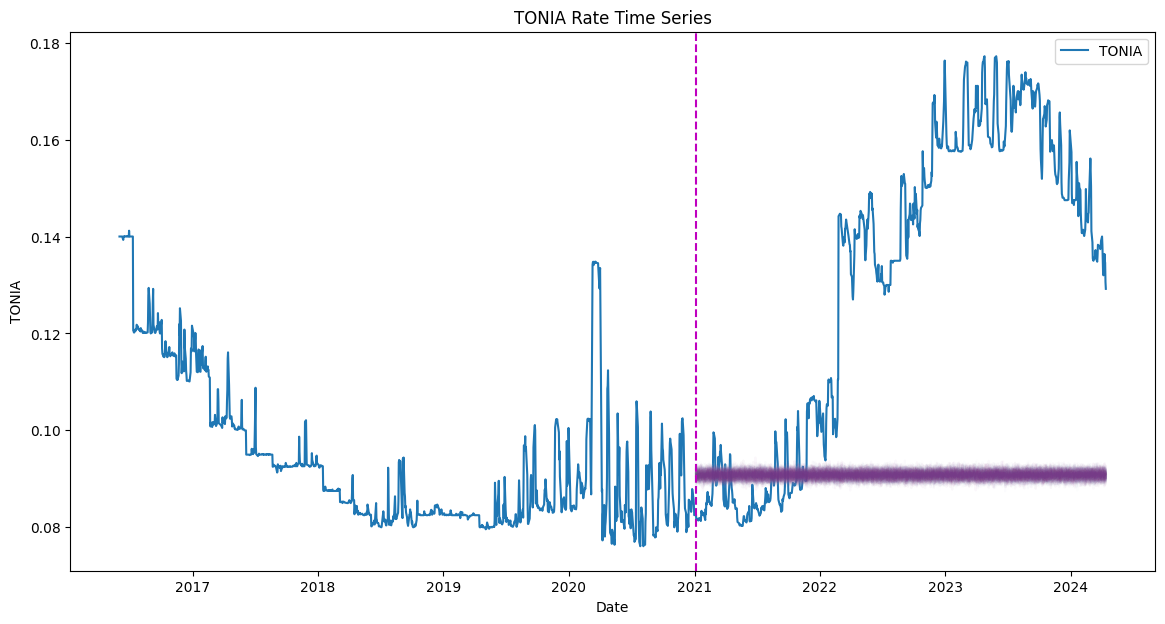

In [66]:
backtester = Backtester(
    rate_model_cls=NeuralModelCalibrated,
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_recent,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
backtester.run(test_start_date=BACKTEST_START_DATES[1])

Simulation result is root_mean_squared_error = 5.6285% p.a.
Total RMSE = 25.574677


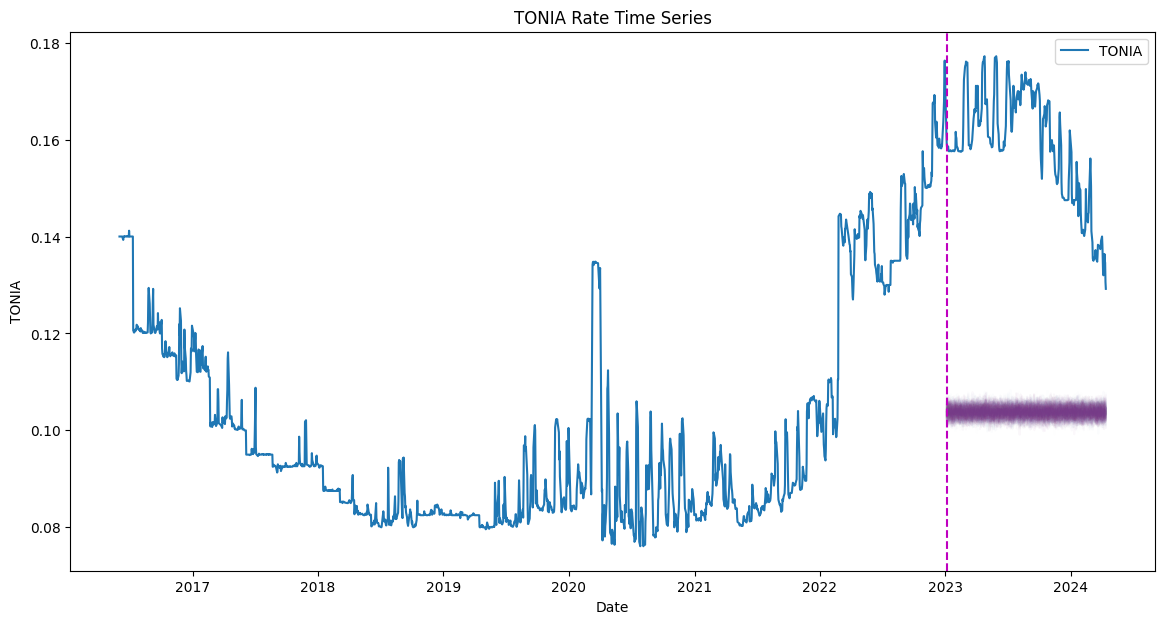

In [67]:
backtester = Backtester(
    rate_model_cls=NeuralModelCalibrated,
    yield_curve_cls=NelsonSiegelCurve,
    data=tonia_recent,
    curve_params=ns_curve_params,
    n_paths=100,
    random_seed=RANDOM_SEED
)
backtester.run(test_start_date=BACKTEST_START_DATES[2])

We see that such a model overfits greatly to the historical average - thus, the model is too powerful for such a small dataset.

**Conclusion:** As we can see from the experiments above, the best model for overnight rate - which is rarely affected by the expectations about CB rate, as it works with realized CB rate - is simple Vasicek. We have tried Neural Networks approach, but due to lack of datapoints, powerful models work less better that the AR(1) process.

Another potential idea for the slightly reformulated task - if we are after the risk management tasks, we might care way more about VaRs of the rates, rather than average (as used here). Therefore, **better optimization would be not MSE minimization, but fitting the Quantile Regression**.